# 1. Imports and Setup

In [1]:
!pip install h2o
!pip install catboost
!pip install keras_tuner
!pip install openai
!pip install transformers
!pip install accelerate
!pip install datasets
!pip install evaluate

In [2]:
import warnings
import re
import math
import string
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, HistGradientBoostingClassifier, BaggingClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeRegressor
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from catboost import CatBoostClassifier

from wordcloud import WordCloud
from nltk.corpus import twitter_samples
from nltk.corpus import words
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, BatchNormalization, SpatialDropout1D, Dropout, Bidirectional, GlobalAveragePooling1D, SimpleRNN, TextVectorization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

import keras_tuner as kt

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
nltk.download('twitter_samples')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('words')

stop = stopwords.words('english')

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /Users/sion/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sion/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sion/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sion/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/sion/nltk_data...
[nltk_data]   Package words is already up-to-date!


# 2. Data Loading

### 2.1 Loading JSON

In [5]:
data_df = pd.read_json('./data/Sarcasm_Headlines_Dataset.json', lines=True)

print(data_df.shape)
data_df.head()

(26709, 3)


,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [6]:
data_df.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

In [7]:
X = data_df['headline']
y = data_df['is_sarcastic']
print(X.shape, y.shape)

(26709,) (26709,)


### 2.2 Class Distribution

Class Distribution: 
 is_sarcastic
0    14985
1    11724
Name: count, dtype: int64


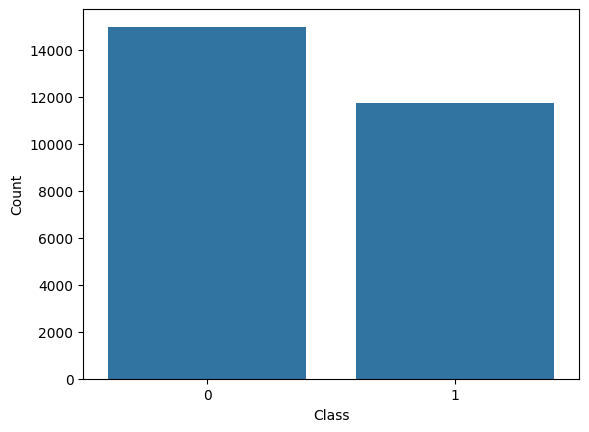

In [8]:
cd = y.value_counts()
print("Class Distribution: \n", cd)

sns.barplot(x=cd.index, y=cd.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### 2.3 Data Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

print(f"Train: {X_train.shape} {X_test.shape} Test: {y_train.shape} {y_test.shape}")

Train: (21367,) (5342,) Test: (21367,) (5342,)


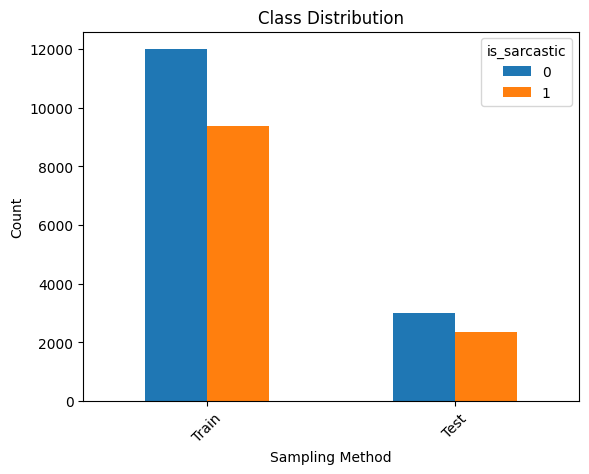

In [11]:
cd_train = y_train.value_counts()
cd_test = y_test.value_counts()

cd_df = pd.DataFrame({
    'Train': cd_train,
    'Test': cd_test,
})

cd_df.T.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Sampling Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 3. Preprocessing

### 3.1 Basic Cleaning

In [12]:
def text_cleaning(text):
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = text.lower()
    return text

In [13]:
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

count = 0
for i in range(len(X_train)):
    original_text = X_train[i]
    cleaned_text = text_cleaning(original_text)
    X_train_clean[i] = cleaned_text

    if original_text != cleaned_text and count<10:
        print("Original: ", original_text)
        print("Cleaned: ", cleaned_text)
        print("-" * 50)
        count +=1

for i in range(len(X_test)):
    original_text = X_test[i]
    cleaned_text = text_cleaning(original_text)
    X_test_clean[i] = cleaned_text

Original:  larry kudlow 'leaning' toward senate run in connecticut
Cleaned:  larry kudlow  leaning  toward senate run in connecticut
--------------------------------------------------
Original:  'everything's $10,000' chain goes out of business
Cleaned:   everything s  chain goes out of business
--------------------------------------------------
Original:  exciting new app allows users to be pawns in 26-year-old ceo's little game
Cleaned:  exciting new app allows users to be pawns in year old ceo s little game
--------------------------------------------------
Original:  u.s. figure skating team makes history with record number of asian-americans
Cleaned:  u s  figure skating team makes history with record number of asian americans
--------------------------------------------------
Original:  patient zero kicking back in 38c with episode of 'new girl'
Cleaned:  patient zero kicking back in 38c with episode of  new girl 
--------------------------------------------------
Original:  what

### 3.2 Stopwords

In [14]:
stopwords = set(stopwords.words('english'))

def remove_stopwords(sentence):
    words = sentence.split()
    clean_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(clean_words)

x_train_clean = X_train.apply(remove_stopwords)
x_test_clean = X_test.apply(remove_stopwords)
print(x_train_clean.head(10))

0                                     fbi raids fridge
1            old el paso introduces emergency taco kit
2    larry kudlow 'leaning' toward senate run conne...
3           'everything's $10,000' chain goes business
4             ceo proves introverts make great leaders
5    dolby theatre usher throws matt damon attempti...
6    exciting new app allows users pawns 26-year-ol...
7          sanders ramps spending effort catch hillary
8    u.s. figure skating team makes history record ...
9     patient zero kicking back 38c episode 'new girl'
Name: headline, dtype: object


### 3.3 Punctuations

In [15]:
def remove_punctuations(sentence):
    return sentence.translate(str.maketrans('', '', string.punctuation))

x_train_clean = x_train_clean.apply(remove_punctuations)
x_test_clean = x_test_clean.apply(remove_punctuations)
print(x_train_clean.head(10))

0                                     fbi raids fridge
1            old el paso introduces emergency taco kit
2    larry kudlow leaning toward senate run connect...
3                everythings 10000 chain goes business
4             ceo proves introverts make great leaders
5    dolby theatre usher throws matt damon attempti...
6    exciting new app allows users pawns 26yearold ...
7          sanders ramps spending effort catch hillary
8    us figure skating team makes history record nu...
9       patient zero kicking back 38c episode new girl
Name: headline, dtype: object


### 3.4 Lemmatization

The `apply_lemmatize` function uses the `WordNetLemmatizer` from NLTK to convert each word in a given text to its base verb form. It splits the text into words, lemmatizes each as a verb, and then joins them back into a single string. For example, “running jumped swimming” becomes “run jump swim”.

In [16]:
lemmatizer = WordNetLemmatizer()
def apply_lemmatize(text):
    words = text.split()
    res = []
    for word in words:
        word = lemmatizer.lemmatize(word, pos='v')
        res.append(word)

    return ' '.join(res)

In [17]:
x_train_clean = x_train_clean.apply(apply_lemmatize)
x_test_clean = x_test_clean.apply(apply_lemmatize)
print(x_train_clean.head(10))

0                                      fbi raid fridge
1             old el paso introduce emergency taco kit
2      larry kudlow lean toward senate run connecticut
3                  everythings 10000 chain go business
4               ceo prove introvert make great leaders
5    dolby theatre usher throw matt damon attempt f...
6    excite new app allow users pawn 26yearold ceos...
7              sanders ramp spend effort catch hillary
8    us figure skate team make history record numbe...
9          patient zero kick back 38c episode new girl
Name: headline, dtype: object


# 4. Feature Extraction

## 4.1 Text Representation for Classical Models

### 4.1.1 Bag of Words: Unigrams

In [18]:
vector = CountVectorizer(max_features = 5000)
x_train_vectors_bow = vector.fit_transform(x_train_clean)
x_test_vectors_bow = vector.transform(x_test_clean)
x_train_vectors_bow

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 125132 stored elements and shape (21367, 5000)>

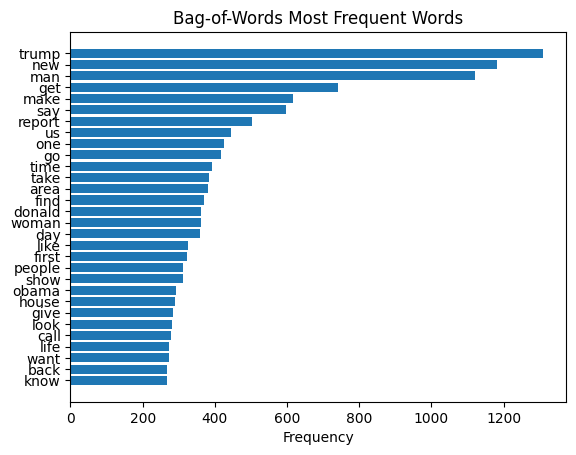

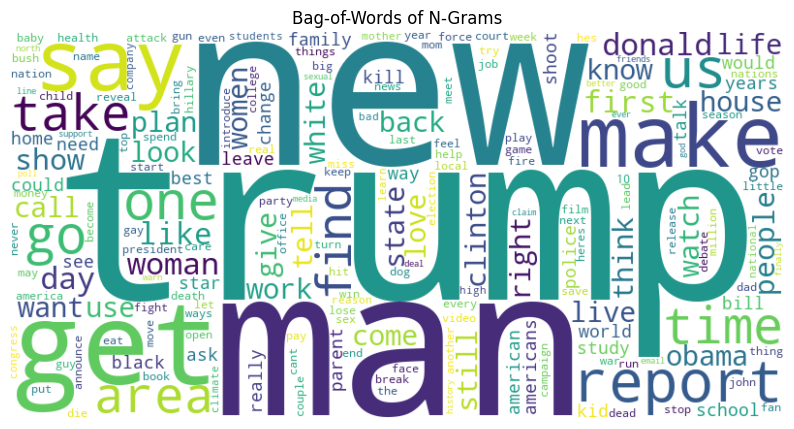

In [19]:
word_counts = np.asarray(x_train_vectors_bow.sum(axis=0)).flatten()
vocab = vector.get_feature_names_out()
word_freq = list(zip(vocab, word_counts))
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)[:30]

words, counts = zip(*word_freq_sorted)
plt.barh(words, counts)
plt.xlabel("Frequency")
plt.title("Bag-of-Words Most Frequent Words")
plt.gca().invert_yaxis()
plt.show()


feature_names = vector.get_feature_names_out()
ngram_counts = np.asarray(x_train_vectors_bow.sum(axis=0)).flatten()
ngram_freq = dict(zip(feature_names, ngram_counts))

wc = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(ngram_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Bag-of-Words of N-Grams")
plt.show()

### 4.1.2 Bag of Words: Unigrams, Bigrams, and Trigrams

In [20]:
vector = CountVectorizer(ngram_range=(1, 3), max_features=5000)
x_train_vectors_bow_ngram = vector.fit_transform(x_train_clean)
x_test_vectors_bow_ngram = vector.transform(x_test_clean)
x_train_vectors_bow_ngram

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 130169 stored elements and shape (21367, 5000)>

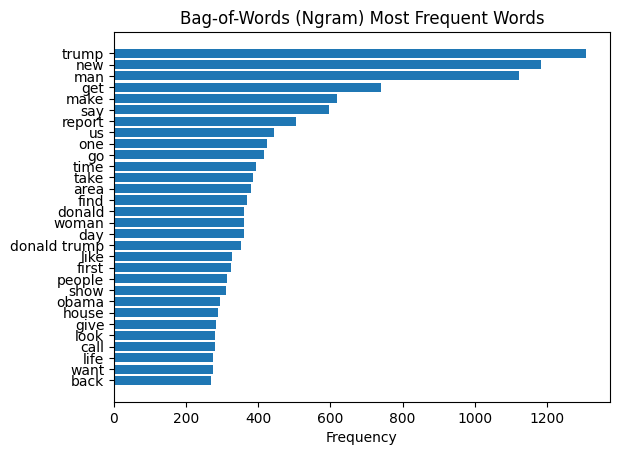

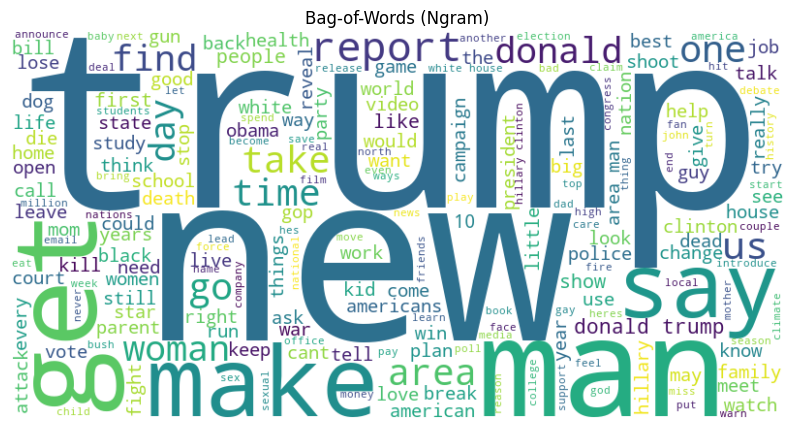

In [21]:
word_counts = np.asarray(x_train_vectors_bow_ngram.sum(axis=0)).flatten()
vocab = vector.get_feature_names_out()
word_freq = list(zip(vocab, word_counts))
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)[:30]

words, counts = zip(*word_freq_sorted)
plt.barh(words, counts)
plt.xlabel("Frequency")
plt.title("Bag-of-Words (Ngram) Most Frequent Words")
plt.gca().invert_yaxis()
plt.show()


feature_names = vector.get_feature_names_out()
ngram_counts = np.asarray(x_train_vectors_bow_ngram.sum(axis=0)).flatten()
ngram_freq = dict(zip(feature_names, ngram_counts))

wc = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(ngram_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Bag-of-Words (Ngram)")
plt.show()

### 4.1.3 TF-IDF: Unigrams

In [22]:
vector = TfidfVectorizer(max_features = 5000)
x_train_vectors_tfidf = vector.fit_transform(x_train_clean)
x_test_vectors_tfidf = vector.transform(x_test_clean)

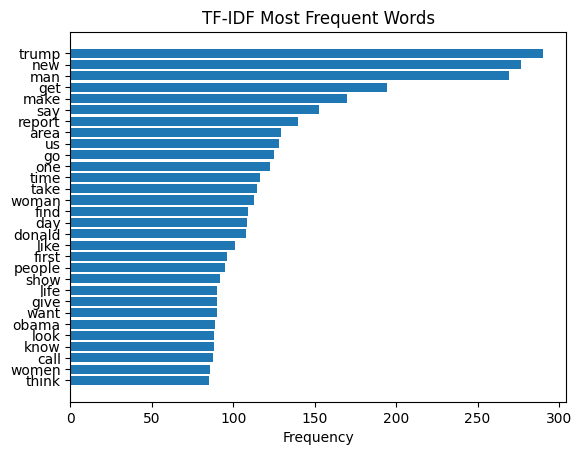

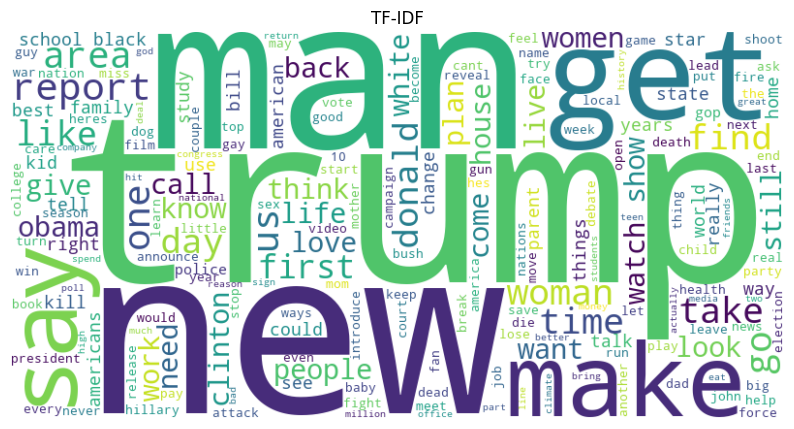

In [23]:
word_counts = np.asarray(x_train_vectors_tfidf.sum(axis=0)).flatten()
vocab = vector.get_feature_names_out()
word_freq = list(zip(vocab, word_counts))
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)[:30]

words, counts = zip(*word_freq_sorted)
plt.barh(words, counts)
plt.xlabel("TF-IDF Score")
plt.title("TF-IDF")
plt.gca().invert_yaxis()
plt.show()


feature_names = vector.get_feature_names_out()
ngram_counts = np.asarray(x_train_vectors_tfidf.sum(axis=0)).flatten()
ngram_freq = dict(zip(feature_names, ngram_counts))

wc = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(ngram_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("TF-IDF")
plt.show()

### 4.1.4 TF-IDF: Unigrams, Bigrams, and Trigrams

In [24]:
vector = TfidfVectorizer(ngram_range=(1, 3), max_features = 5000)
x_train_vectors_tfidf_ngram = vector.fit_transform(x_train_clean)
x_test_vectors_tfidf_ngram = vector.transform(x_test_clean)

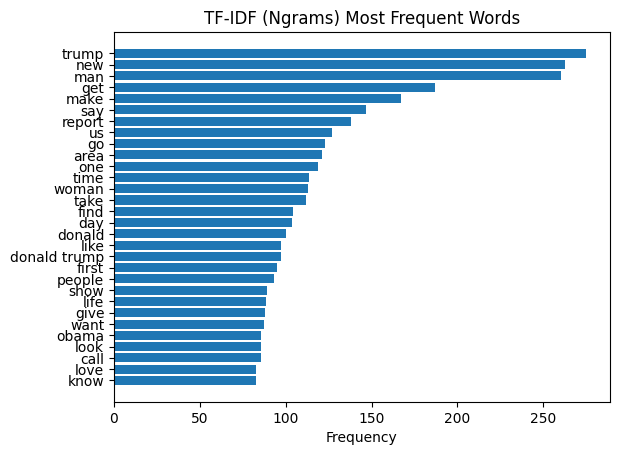

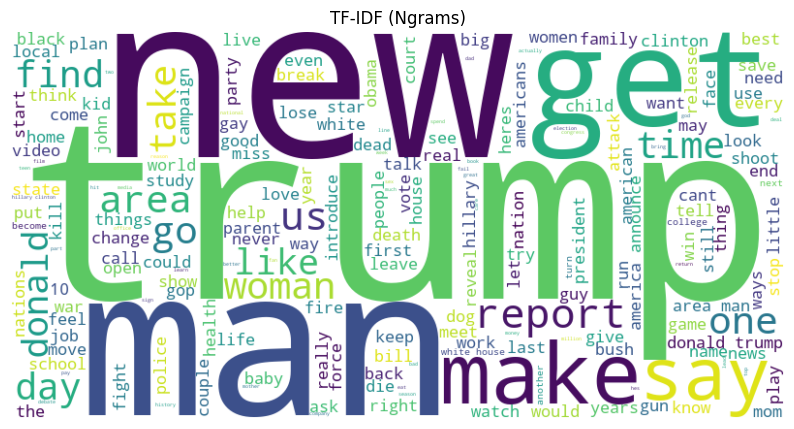

In [25]:
word_counts = np.asarray(x_train_vectors_tfidf_ngram.sum(axis=0)).flatten()
vocab = vector.get_feature_names_out()
word_freq = list(zip(vocab, word_counts))
word_freq_sorted = sorted(word_freq, key=lambda x: x[1], reverse=True)[:30]

words, counts = zip(*word_freq_sorted)
plt.barh(words, counts)
plt.xlabel("TF-IDF Score")
plt.title("TF-IDF (Ngrams)")
plt.gca().invert_yaxis()
plt.show()


feature_names = vector.get_feature_names_out()
ngram_counts = np.asarray(x_train_vectors_tfidf_ngram.sum(axis=0)).flatten()
ngram_freq = dict(zip(feature_names, ngram_counts))

wc = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(ngram_freq)

plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("TF-IDF (Ngrams)")
plt.show()

### 4.1.5 Comparison

Performance for Bag-of-Words
Accuracy: 0.7632
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80      2997
           1       0.79      0.63      0.70      2345

    accuracy                           0.76      5342
   macro avg       0.77      0.75      0.75      5342
weighted avg       0.77      0.76      0.76      5342

Performance for Bag-of-Words (Ngrams)
Accuracy: 0.7647
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.81      2997
           1       0.79      0.63      0.70      2345

    accuracy                           0.76      5342
   macro avg       0.77      0.75      0.75      5342
weighted avg       0.77      0.76      0.76      5342

Performance for TF-IDF
Accuracy: 0.7638
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.86      0.80      2997
           1       0.79    

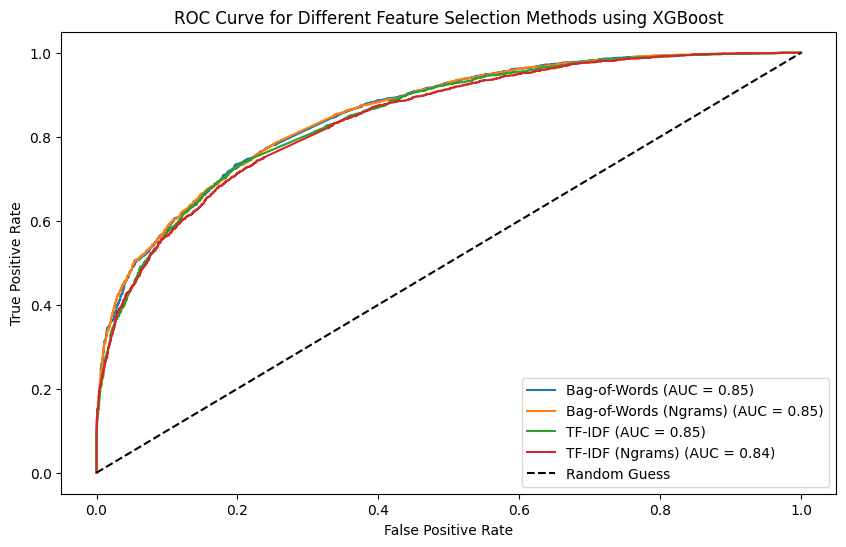

In [26]:
datasets = {
    "Bag-of-Words": (x_train_vectors_bow, x_test_vectors_bow),
    "Bag-of-Words (Ngrams)": (x_train_vectors_bow_ngram, x_test_vectors_bow_ngram),
    "TF-IDF": (x_train_vectors_tfidf, x_test_vectors_tfidf),
    "TF-IDF (Ngrams)": (x_train_vectors_tfidf_ngram, x_test_vectors_tfidf_ngram),
}

results = {}
fig, ax = plt.subplots(figsize=(10, 6))

for name, (x_train, x_test) in datasets.items():
    model = XGBClassifier(n_estimators=500, eval_metric="logloss", random_state=42, n_jobs=-1)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"Performance for {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    y_val_proba = model.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_val_proba)
    auc_score = roc_auc_score(y_test, y_val_proba)

    ax.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random Guess")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Different Feature Selection Methods using XGBoost")
ax.legend(loc="lower right")
plt.show()

Each Feacture Selection Method for Vectorization has similar performance. TF-IDF unigrams are chosen.

In [27]:
x_train_vectors = x_train_vectors_tfidf
x_test_vectors = x_test_vectors_tfidf

### 4.2 Sequence-Based Text Representation

#### 4.2.1 Tokenization

The provided code snippet initializes a `Tokenizer` from the Keras library for text preprocessing in natural language processing tasks. Here’s a brief explanation of each component:
- `max_features = 500000`: Sets the maximum number of words to keep based on word frequency. Only the top 500,000 most common words will be retained in the tokenizer’s vocabulary.
- `max_length = 30`: Typically defines the maximum length of sequences after tokenization, often used later with padding or truncation.

`Tokenizer` Initialization:
- `num_words=max_features`: Limits the tokenizer to the most frequent 500,000 words.
- `split=' '`: Specifies that words in the input text should be split by spaces.
- `filters=string.punctuation`: Removes all punctuation from the text before tokenization.
- `lower=True`: Converts all text to lowercase before tokenization, ensuring uniformity in word representation.
This setup is commonly used in preparing text data for training machine learning models, particularly in tasks like text classification or sentiment analysis.


In [28]:
max_features = 500000  # Maximum number of words to keep
max_length = 30

tokenizer = Tokenizer(
    num_words=max_features,
    split=' ',
    filters=string.punctuation,
    lower=True
)
tokenizer.fit_on_texts(x_train_clean.values)
vocab_size = len(tokenizer.word_index) + 1

x_train_token = tokenizer.texts_to_sequences(x_train_clean)
x_train_token = pad_sequences(x_train_token, maxlen=max_length, padding='post', truncating='post')
x_test_token = tokenizer.texts_to_sequences(x_test_clean)
x_test_token = pad_sequences(x_test_token, maxlen=max_length, padding='post', truncating='post')
x_train_token

array([[  570,  1629,  3816, ...,     0,     0,     0],
       [  256,  2870, 10784, ...,     0,     0,     0],
       [ 1800, 10785,  3456, ...,     0,     0,     0],
       ...,
       [  351,   277,  1150, ...,     0,     0,     0],
       [21391,   111,  2145, ...,     0,     0,     0],
       [ 9769, 10457,  1593, ...,     0,     0,     0]], dtype=int32)

In [29]:
print('Found %s unique tokens.' % len(tokenizer.word_index))
print('Sequence shape:', x_train_token.shape)

Found 21396 unique tokens.
Sequence shape: (21367, 30)


#### 4.2.2 Sequence-based Vectorization

In [30]:
encoder = TextVectorization(max_tokens = 10000,
                            output_mode='int',
                            output_sequence_length=64)
encoder.adapt(X_train) #x_train_clean

In [31]:
vocabulary = np.array(encoder.get_vocabulary())

example = tf.constant([X_train[0]])  ##### x_train_clean
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b'fbi raids fridge'
encoded:  [ 598 4549 4779    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
decoded:  fbi raids fridge                                                             


In [32]:
x_train_vectors_nn = encoder(np.array(X_train)).numpy() ##### x_train_clean
y_train_vectors_nn = np.array(y_train).astype('float32')

x_test_vectors_nn = encoder(np.array(X_test)).numpy() ###### x_test_clean
y_test_vectors_nn = np.array(y_test).astype('float32')

# 5. Model Training

### 5.1 Traditional Models

#### 5.1.1 Model Selection

In [33]:
classic_models = {
    "Logistic Regressor": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(verbose=0),
    "Extra Trees": ExtraTreesClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Bagging": BaggingClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0)
}

#### 5.1.2 Param Grids

In [34]:
param_grids = {
    "Logistic Regressor":{
        "penalty": ["l2"], # [‘l1’, ‘elasticnet’]
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "tol": [0.001, 0.0001, 0.00001],
        "solver": ["lbfgs","liblinear", "saga"],
        "max_iter": [5000]
    },
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [10, 20, 30, 50, None],
        "min_samples_split": [2, 5, 10, 25],
        "min_samples_leaf": [1, 2, 5, 10]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [10, 20, 40, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "subsample": [0.7, 0.8, 1.0]
    },
    "XGBoost": {
        "n_estimators": [100, 250, 500, 1000],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "max_depth": [3, 5, 7],
        "eval_metric": ["logloss"],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 0.1, 0.3, 0.5]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.2],
        "num_leaves": [20, 31, 40],
        "max_bin": [63, 127, 255],
        "min_child_samples": [10, 20, 30, 50],
        "boosting_type": ["gbdt", "dart"]
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "max_features": ["sqrt", "log2", None],
        "min_samples_leaf": [1, 2, 5],
        "bootstrap": [True, False]
    },
    "AdaBoost": {
        "n_estimators": [10, 50, 100, 200, 500],
        "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0],
        "algorithm": ["SAMME"],
    },
    "Bagging": {
        "n_estimators": [10, 25, 50, 100],
        "max_samples": [0.5, 0.7, 0.9, 1.0],
        "max_features": [0.2, 0.5, 0.8, 1.0],
        "bootstrap": [True, False]
    },
    "CatBoost":{
        "iterations": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "depth": [3, 5, 7],
        "l2_leaf_reg": [1, 3, 5, 10],
        "bagging_temperature": [0, 0.5, 1.0],
        "grow_policy": ["SymmetricTree", "Depthwise", "Lossguide"]
    },
}

#### 5.1.3 Training

In [35]:
classic_results = {}
for model_name, model in classic_models.items():
    print(f"Training {model_name}...")

    search = RandomizedSearchCV(
        model,
        param_distributions=param_grids[model_name],
        n_iter=20,
        scoring={
            'f1': make_scorer(f1_score, average='weighted'),
            'accuracy': make_scorer(accuracy_score)
        },
        refit='f1',
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(x_train_vectors, y_train)
    classic_results[model_name] = {"cv_results": pd.DataFrame(search.cv_results_), "best_estimator": search.best_estimator_}

Training Logistic Regressor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training Decision Tree...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training Random Forest...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training Gradient Boosting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training Extra Trees...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training AdaBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training Bagging...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Training CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


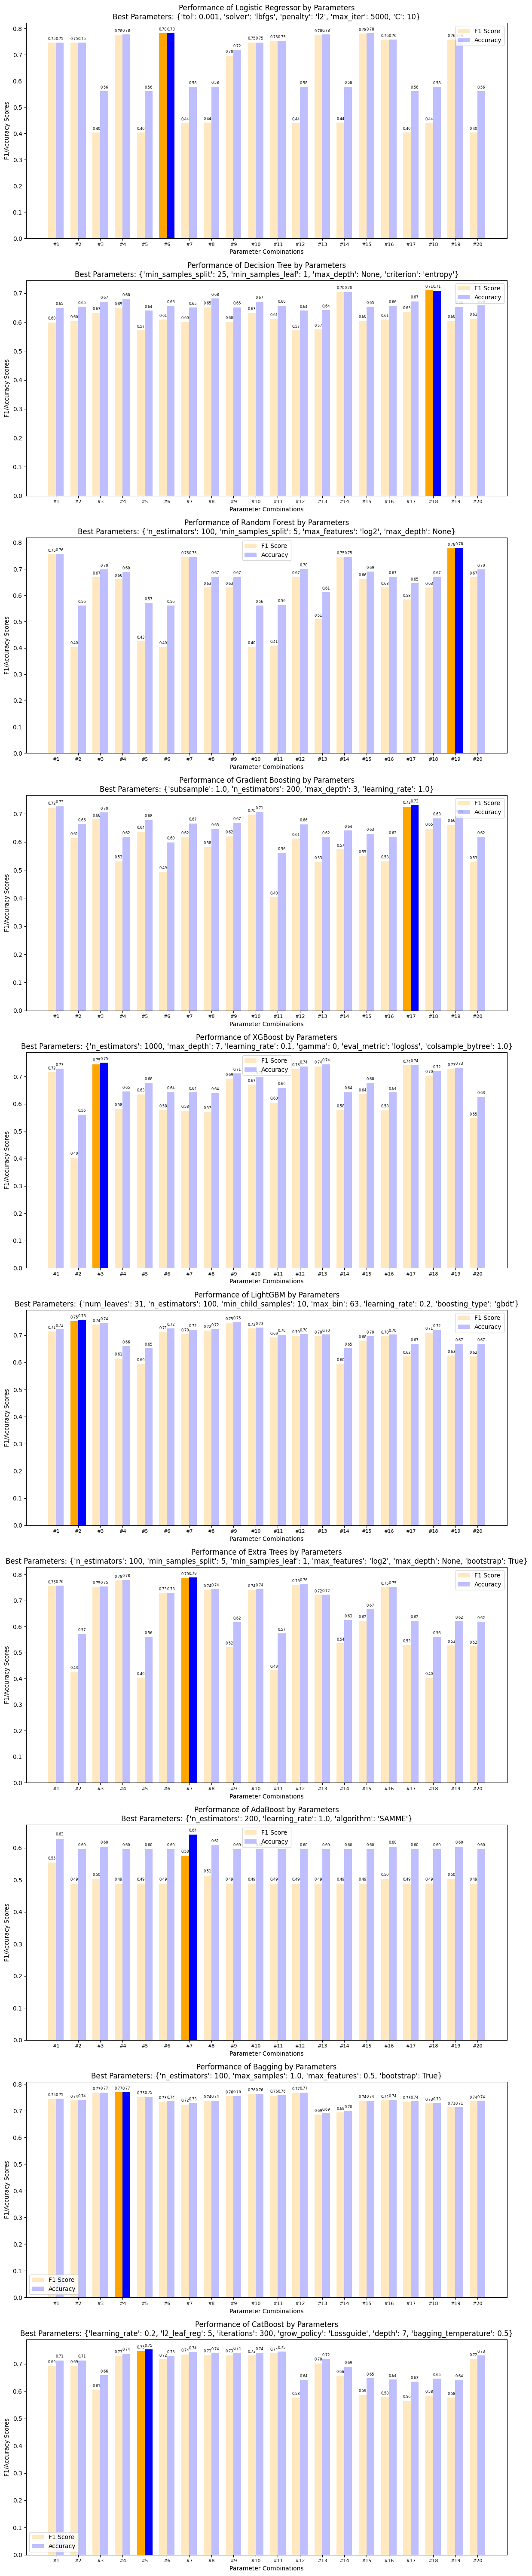

In [36]:
fig, axes = plt.subplots(len(classic_results), 1, figsize=(12, 6 * len(classic_results)))

for ax, (model_name, model_data) in zip(axes, classic_results.items()):
    # Best parameter combination
    best_index = model_data["cv_results"]["rank_test_f1"].idxmin()

    # F1 and Accuracy Scores
    f1_scores = model_data["cv_results"]["mean_test_f1"]
    accuracy_scores = model_data["cv_results"]["mean_test_accuracy"]

    for i, f1 in enumerate(f1_scores):
        ax.bar(
            i - 0.35 / 2,
            f1,
            width=0.35,
            color='orange' if i == best_index else 'orange',
            alpha=1.0 if i == best_index else 0.25,
            label='F1 Score' if i == 0 else None
        )
    for i, acc in enumerate(accuracy_scores):
        ax.bar(
            i + 0.35 / 2,
            acc,
            width=0.35,
            color='blue' if i == best_index else 'blue',
            alpha=1.0 if i == best_index else 0.25,
            label='Accuracy' if i == 0 else None
        )

    for i, (f1, acc) in enumerate(zip(f1_scores, accuracy_scores)):
        ax.text(i - 0.35 / 2, f1 + 0.01, f"{f1:.2f}", ha="center", fontsize=6)
        ax.text(i + 0.35 / 2, acc + 0.01, f"{acc:.2f}", ha="center", fontsize=6)

    ax.set_title(f"Performance of {model_name} by Parameters\nBest Parameters: {model_data['cv_results'].loc[best_index, 'params']}")
    ax.set_xlabel("Parameter Combinations")
    ax.set_ylabel("F1/Accuracy Scores")
    ax.set_xticks(range(len(model_data["cv_results"])))
    ax.set_xticklabels([f"#{i+1}" for i in range(len(model_data["cv_results"]))], rotation=0, ha="center", fontsize=8)
    ax.legend()

plt.tight_layout()
plt.show()

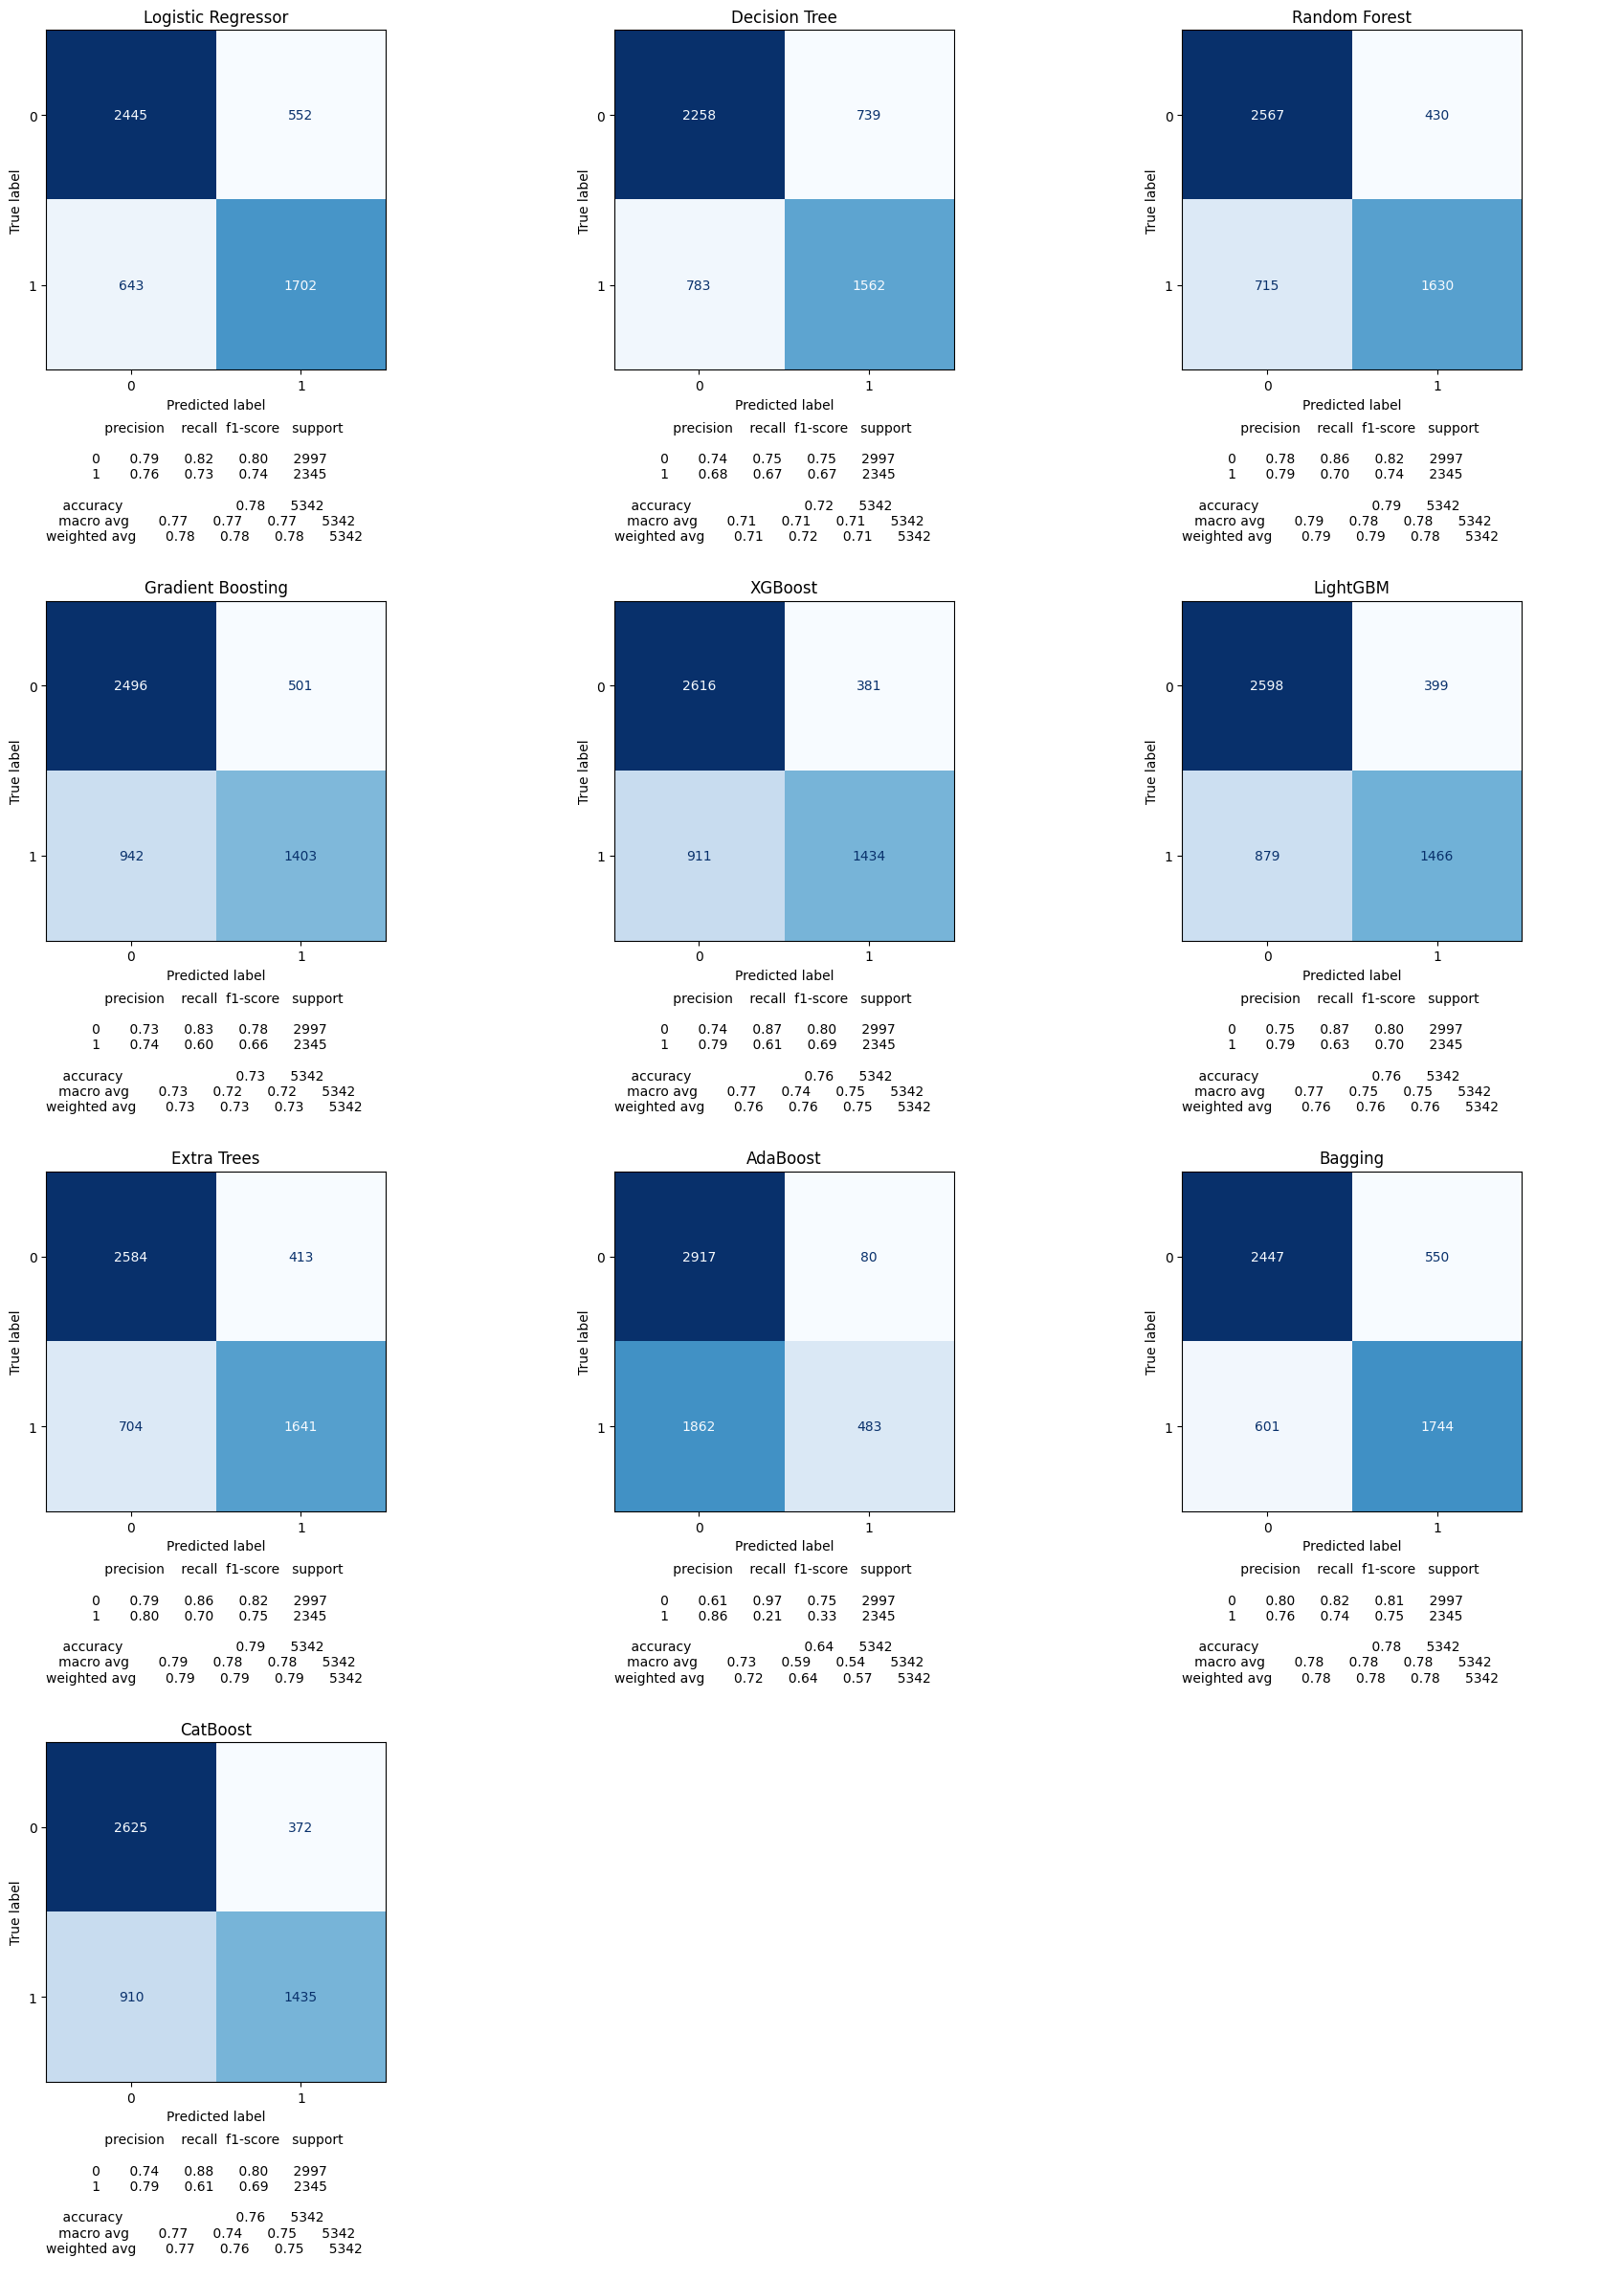

In [37]:
n_rows = math.ceil(len(classic_results) / 3)
fig, axes = plt.subplots(n_rows, 3, figsize=(18, 6 * n_rows))

for ax, (model_name, model_data) in zip(axes.flatten(), classic_results.items()):
    best_model = model_data["best_estimator"]
    y_test_pred = best_model.predict(x_test_vectors)

    # Confusion_matrix
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(ax=ax, cmap='Blues', colorbar=False)
    ax.set_title(f"{model_name}")

    # Classification report
    report = classification_report(y_test, y_test_pred)
    ax.text(0.0, -0.15, report, transform=ax.transAxes, fontsize=10, va='top', wrap=True)

# Unused subplots
for ax in axes.flatten()[len(classic_results):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

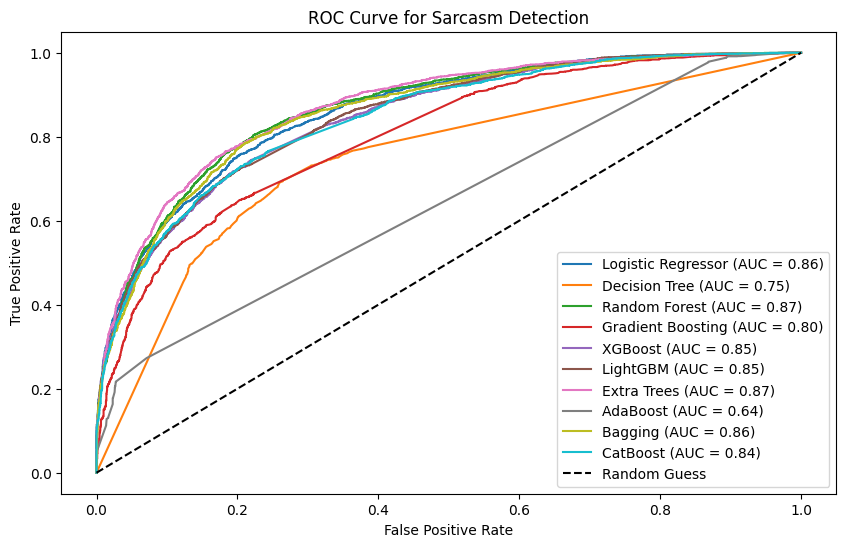

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model_data in classic_results.items():
    best_model = model_data["best_estimator"]

    # Probabilities for is_sarcastic=1
    y_test_proba = best_model.predict_proba(x_test_vectors)[:, 1]

    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    auc_score = roc_auc_score(y_test, y_test_proba)

    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random Guess") # For reference
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Sarcasm Detection")
ax.legend(loc="lower right")
plt.show()

In [44]:
np.random.seed(42)
random_indices = np.random.choice(len(y_test), size=10, replace=False)

samples_dict = {}
samples_dict["Headline"] = np.array(X_test)[random_indices]
samples_dict["True Label"] = np.array(y_test)[random_indices]

for model_name, model_data in classic_results.items():
    best_model = model_data["best_estimator"]
    y_test_pred = best_model.predict(x_test_vectors)
    y_test_pred_array = np.array(y_test_pred)
    samples_dict[model_name] = y_test_pred_array[random_indices]

samples_df = pd.DataFrame(samples_dict)

light_red = "rgba(255, 0, 0, 0.15)" 
light_blue = "rgba(0, 0, 255, 0.15)"  

styled_df = samples_df.style.apply(
    lambda row: [
        f'background-color: {light_red}' if col_name not in ["Headline", "True Label"] and row["True Label"] != row[col_name]
        else (f'background-color: {light_blue}' if col_name not in ["Headline", "True Label"] and row["True Label"] == row[col_name]
              else '') 
        for col_name in samples_df.columns
    ], 
    axis=1
)
styled_df

,Headline,True Label,Logistic Regressor,Decision Tree,Random Forest,Gradient Boosting,XGBoost,LightGBM,Extra Trees,AdaBoost,Bagging,CatBoost
0,new walgreens facebook plugin allows users to see what prescriptions friends are picking up,1,1,1,1,1,1,1,1,0,1,1
1,dozens of social issues thankful they never had to go toe-to-toe with muhammad ali,1,0,0,0,0,1,1,0,0,1,1
2,"at dnc, democrats spoke out on a topic that republicans mostly avoided",0,0,1,0,0,0,0,0,0,0,0
3,local couple celebrates birth of son with ritual genital mutilation,1,1,1,1,1,0,1,1,0,1,1
4,senate votes to add gratuity to all bills of eight provisions or more,1,1,1,1,1,0,0,1,0,1,0
5,"hulu's 'the handmaid's tale' adds joseph fiennes, will be b-a-n-a-n-a-s",0,0,1,1,0,1,1,0,0,1,1
6,trump's daca decision turns its back on our nation's principles,0,1,0,0,1,0,0,1,0,1,0
7,parents of girl born without nose tell others not to give up on babies with rare condition,0,1,1,0,0,0,0,0,0,1,0
8,bernie sanders agrees to drop out of race in exchange for 13-hour speaking slot at convention,1,0,0,0,0,0,0,0,0,0,0
9,men don't have it all,0,0,0,0,0,0,0,0,0,0,0


In [40]:
# for future use, we lock in the best model from this stage (which was extra trees) with the corresponding best hyperparameters
best_classic_model = ExtraTreesClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=1, max_features='log2', max_depth=None, bootstrap=True).fit(x_train_vectors, y_train)

In [41]:
# verify scores generally match values from random search
print('acc', best_classic_model.score(x_test_vectors, y_test))
print('auc', roc_auc_score(y_test, best_classic_model.predict_proba(x_test_vectors)[:, 1]))

acc 0.791463871209285
auc 0.8713027170738614


### 5.2 Neural Networks

#### 5.2.1 Simple RNN

In [48]:
model = Sequential()
model.add(Input(shape = (max_length,)))
model.add(Embedding(input_dim = vocab_size, output_dim = 64))
model.add(SimpleRNN(64, return_sequences = True))
model.add(Dropout(0.3))
model.add(SimpleRNN(32, return_sequences = False))
model.add(Dropout(0.3))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 30, 64)              │       1,366,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 30, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,378,433 (5.26 MB)

 Trainable params: 1,378,433 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = model.fit(x_train_token, y_train,
                    epochs = 10,
                    validation_split=0.2,
                    batch_size = 32)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.5888 - loss: 0.6705 - val_accuracy: 0.7464 - val_loss: 0.5262
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.8413 - loss: 0.3917 - val_accuracy: 0.7773 - val_loss: 0.5083
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9481 - loss: 0.1590 - val_accuracy: 0.7709 - val_loss: 0.6513
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9756 - loss: 0.0801 - val_accuracy: 0.7574 - val_loss: 0.8396
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9875 - loss: 0.0436 - val_accuracy: 0.7595 - val_loss: 0.9731
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.9903 - loss: 0.0357 - val_accuracy: 0.7646 - val_loss: 1.2469
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9898 - loss: 0.0332 - val_accuracy: 0.7515 - val_loss: 1.1509
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.9934 - loss: 0.0218 - 

In [50]:
loss, accuracy = model.evaluate(x_test_token, y_test)
print(f"Accuracy: {accuracy:.2f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7569 - loss: 1.3602
Accuracy: 0.76


In [51]:
# save best simple rnn for future use
best_simple_rnn_model = model

### 5.2.2 LSTM Model #1

The information source: @https://medium.com/@neri.vvo/how-to-use-lstm-in-nlp-tasks-text-classification-example-3222db759337#:~:text=In%20NLP%2C%20LSTMs%20are%20typically,previous%20inputs%20in%20%E2%80%9Cmemory.%E2%80%9D

Natural language processing (NLP) tasks frequently employ the Recurrent Neural Network (RNN) variant known as Long Short-Term Memory (LSTM). RNNs are neural networks that process sequential data, such as time series data or text written in a natural language.

### Central Role of an LSTM Model

- **Cell State**:
  - The key component of an LSTM model is the **cell state**, which maintains its state over time.
  - The **cell state** can be visualized as a horizontal line running through the top of the diagram.
  - The cell state functions like a conveyor belt through which information flows, mostly unchanged.
  - Information can be added or removed from the cell state through gates, which control the flow of information in and out.

- **Gates in LSTM**:
  - LSTMs have a set of gates that regulate the flow of information:
    - **Input Gate**: Controls the flow of new information into the cell.
    - **Forget Gate**: Regulates the flow of information out of the cell.
    - **Output Gate**: Manages the data flow into the LSTM’s output.

- **Mechanism of Operation**:
  - LSTMs use a system of **memory cells** that store information and transmit it across time steps.
  - These cells are interconnected by gates, which ensure that only the relevant information is retained and passed along.
  - The gates employ pointwise multiplication and a **sigmoid neural net layer** to manage the information flow.

### Summary of Gate Functions
- **Input Gate**: Adds new information to the cell state.
- **Forget Gate**: Removes unnecessary information from the cell state.
- **Output Gate**: Sends relevant information to the output.
  
By controlling the flow of information in this way, LSTMs can **forget irrelevant information** while **retaining important data** over longer sequences.

In [56]:
model = Sequential()
model.add(Embedding(
                input_dim=len(tokenizer.word_index) + 1,
                output_dim=30,
                input_length=max_length,
                trainable=True
            )
         )
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100,
               return_sequences=False,
              )
         ))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
                64,
                activation='relu',
                kernel_regularizer=l2(0.001)
            )
         )
model.add(Dropout(0.4))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=['acc'])
model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ (None, 30, 30)              │         640,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ (None, 30, 30)              │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 200)                 │         104,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          12,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,089 (2.90 MB)

 Trainable params: 758,689 (2.89 MB)

 Non-trainable params: 400 (1.56 KB)

The provided code defines and compiles a neural network model using the Keras library, specifically for a binary classification task. Here’s a breakdown of each component in the model:

**Model Architecture**<br>

1. Sequential Model:<br>
   The model is created using Keras’ `Sequential` API, which allows for building a linear stack of layers.

2. Embedding Layer:<br>
   `input_dim=len(tokenizer.word_index) + 1`: Sets the size of the vocabulary. It is based on the tokenizer’s word index size plus one for padding or unknown tokens.<br>
    `output_dim=30`: The dimension of the dense embedding vectors.<br>
	`input_length=max_length`: The length of input sequences, set to 30.<br>
	`trainable=True`: Allows the embedding weights to be updated during training.<br>
3. SpatialDropout1D Layer:<br>
   Applies dropout to the 1D input to prevent overfitting, with a dropout rate of 0.3.<br>
4. Bidirectional LSTM Layer:<br>
   `LSTM(100)`: An LSTM layer with 100 units.<br>
   `return_sequences=False`: Outputs only the last output in the output sequence.<br>
   Wrapped in `Bidirectional`, which processes input from both directions to capture dependencies in sequences more effectively.<br>
5. BatchNormalization Layer:<br>
   Normalizes the inputs of the layer to improve convergence and stability during training.<br>
6. Dropout Layer:<br>
   Adds dropout with a rate of 0.3 to reduce overfitting by randomly setting input units to zero during training.<br>
7. Dense Layer:<br>
   `units=64`: A fully connected layer with 64 neurons.<br>
   `activation='relu'`: Uses ReLU activation function.<br>
   `kernel_regularizer=l2(0.001)`: Applies L2 regularization to reduce overfitting.<br>
8. Another Dropout Layer:<br>
   Adds dropout with a rate of 0.4 for further regularization.<br>
9. Output Dense Layer:<br>
   `units=1`, `activation='sigmoid'`: A single neuron output layer with sigmoid activation for binary classification.<br>

**Compilation**<br>
- Optimizer: `adam`, which is an adaptive learning rate optimization algorithm.
- Loss Function: `binary_crossentropy`, suitable for binary classification tasks.
- Metrics: `acc`, which tracks accuracy during training and evaluation.

**Model Summary**<br>
- The `model.summary()` call provides a summary of the model architecture, including each layer’s type, output shape, and number of parameters.

This model is designed for text-based binary classification tasks, such as sentiment analysis, where it learns to classify sequences into one of two categories.

In [57]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001
)
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

The code snippet sets up three Keras callbacks to enhance the training process of a neural network model: `EarlyStopping`, `ReduceLROnPlateau`, and `ModelCheckpoint`. Below is a brief explanation of each:

1. EarlyStopping
- **Purpose**: Stops training when the monitored metric, `val_loss` (validation loss), stops improving.
- **Parameters**:
  - `monitor='val_loss'`: Monitors the validation loss.
  - `patience=10`: Waits for 10 epochs without improvement before stopping.
  - `restore_best_weights=True`: Restores the model weights from the epoch with the best validation loss, ensuring the best model is used.

2. ReduceLROnPlateau
- **Purpose**: Reduces the learning rate when a metric has stopped improving, allowing finer adjustments to weights.
- **Parameters**:
  - `monitor='val_loss'`: Monitors the validation loss.
  - `factor=0.2`: Reduces the learning rate by multiplying it by 0.2.
  - `patience=5`: Waits for 5 epochs without improvement before reducing the learning rate.
  - `min_lr=0.00001`: Sets a lower bound on the learning rate.

3. ModelCheckpoint
- **Purpose**: Saves the model or weights at specified intervals, particularly when performance improves.
- **Parameters**:
  - `filepath='best_model.keras'`: Path where the model is saved.
  - `monitor='val_loss'`: Monitors the validation loss to determine when to save.
  - `save_best_only=True`: Saves only when there is an improvement in validation loss, ensuring that only the best-performing model is retained.<br>

**Summary**
- These callbacks help optimize training by:
    - Preventing overfitting.
    - Dynamically adjusting learning rates.
    - Ensuring that the best model configuration is saved.

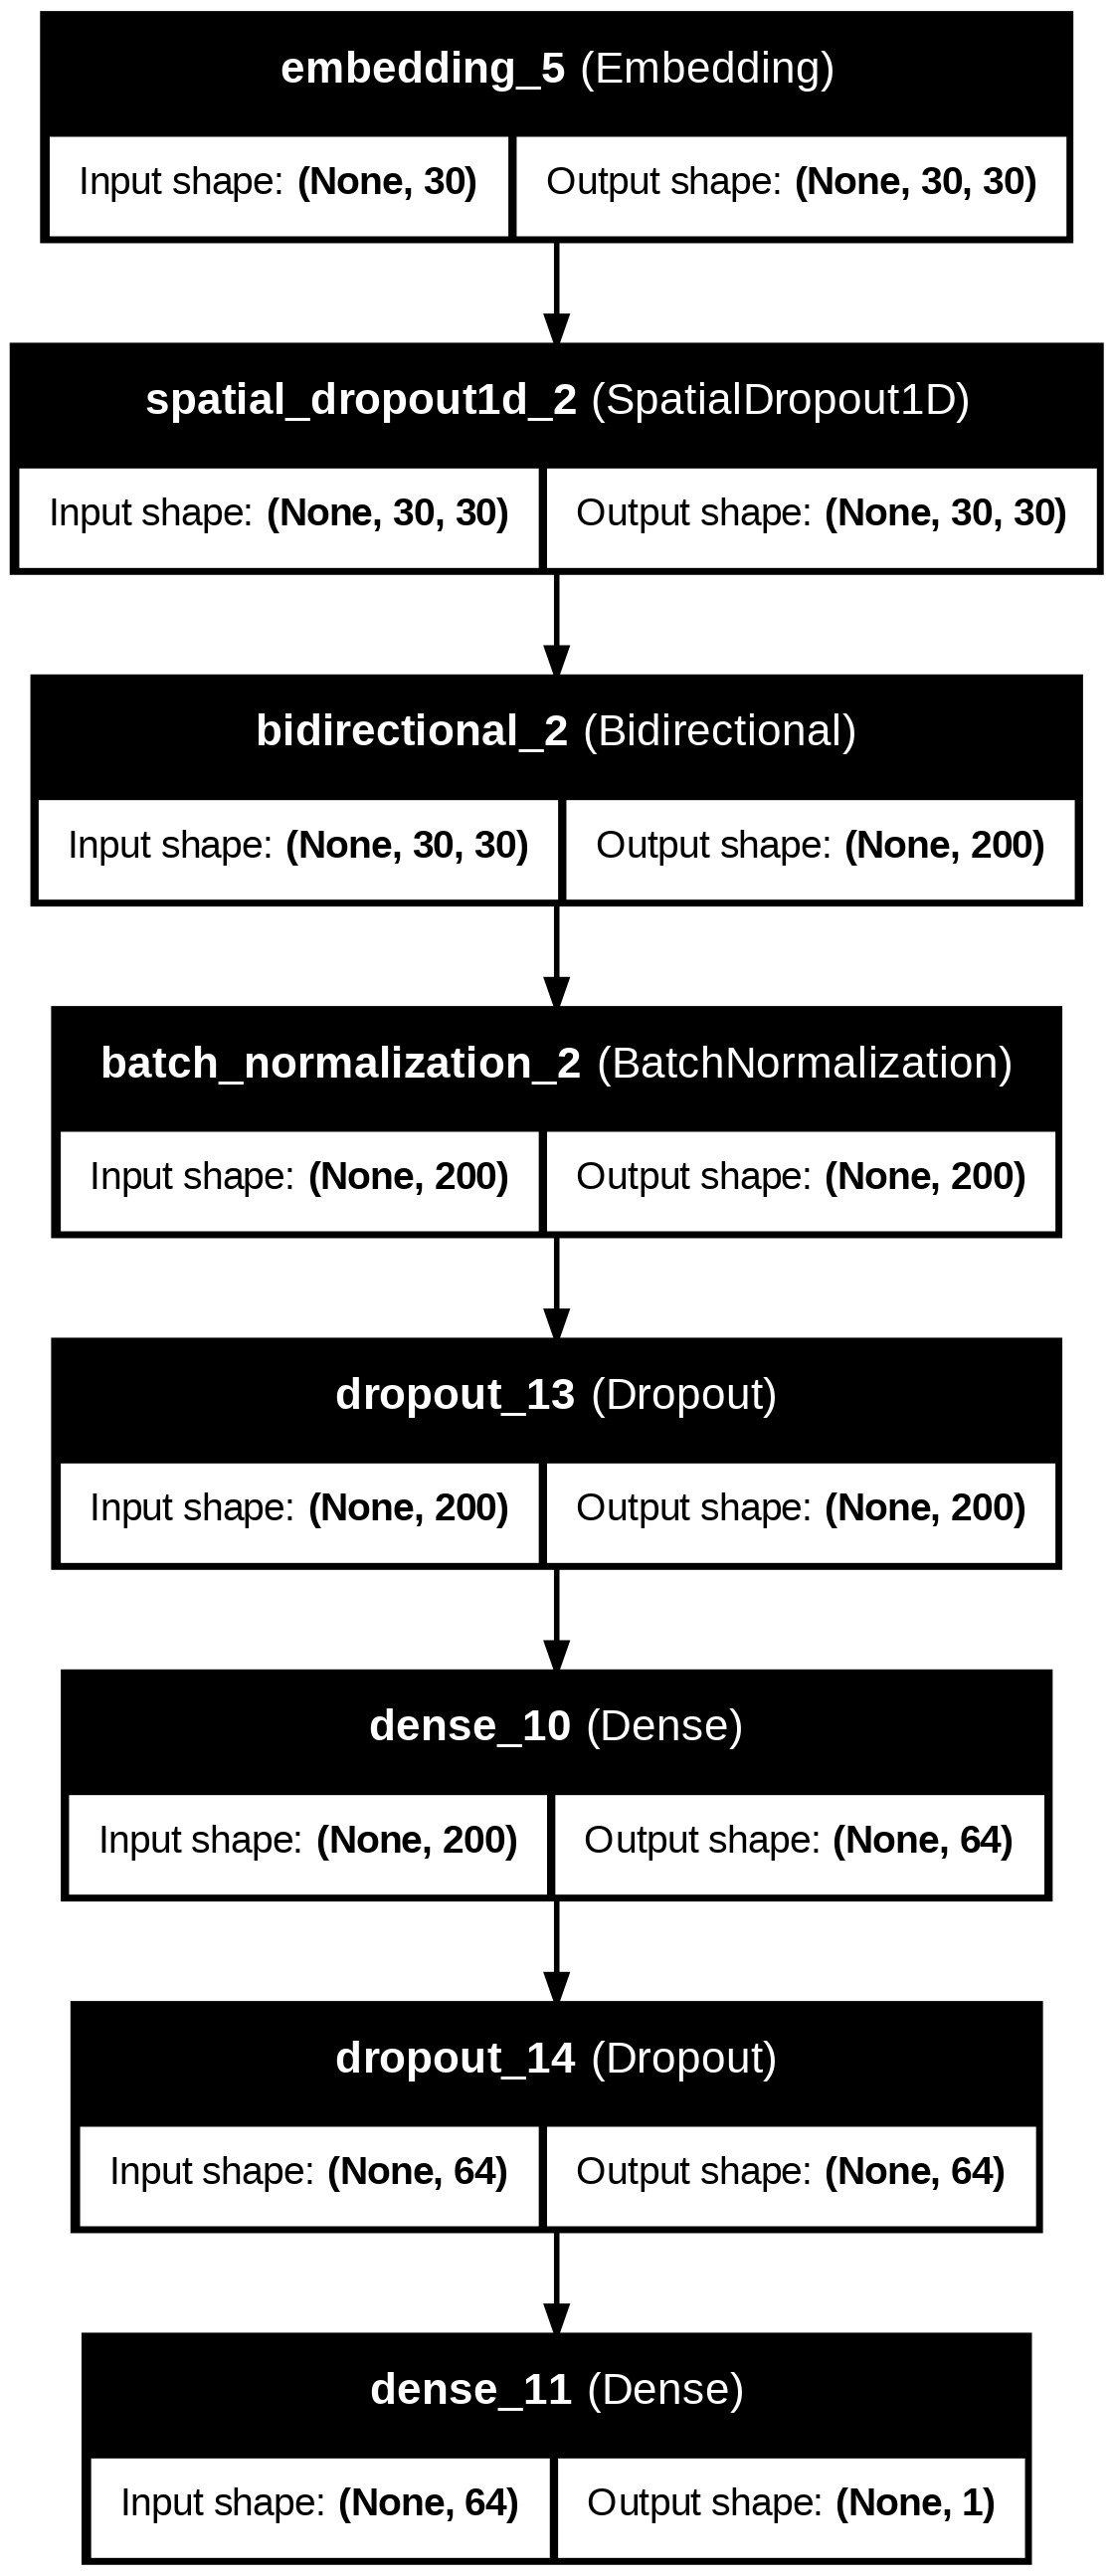

In [58]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [59]:
batch_size = 32

history = model.fit(
    x_train_token,
    y_train,
    epochs=15,
    batch_size=batch_size,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose = 1)

Epoch 1/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - acc: 0.6469 - loss: 0.6792 - val_acc: 0.7728 - val_loss: 0.5194 - learning_rate: 0.0010
Epoch 2/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - acc: 0.8693 - loss: 0.3345 - val_acc: 0.7805 - val_loss: 0.4759 - learning_rate: 0.0010
Epoch 3/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - acc: 0.9320 - loss: 0.1949 - val_acc: 0.7892 - val_loss: 0.5546 - learning_rate: 0.0010
Epoch 4/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - acc: 0.9579 - loss: 0.1279 - val_acc: 0.7707 - val_loss: 0.6346 - learning_rate: 0.0010
Epoch 5/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - acc: 0.9620 - loss: 0.1111 - val_acc: 0.7688 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 6/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - acc: 0.9703 - loss: 0.0870 - val_acc: 0.7520 - val_loss: 1.0869 - learning_rate: 0.0010
Epoch 7/15
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - acc: 0.9740 - loss: 0.0754 - val_acc: 0.7667 - val_loss: 0.9224 - learning_rate:

In [60]:
test_loss, test_accuracy = model.evaluate(x_test_token, y_test, verbose=0)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")

Test accuracy: 0.78
Test loss: 0.49


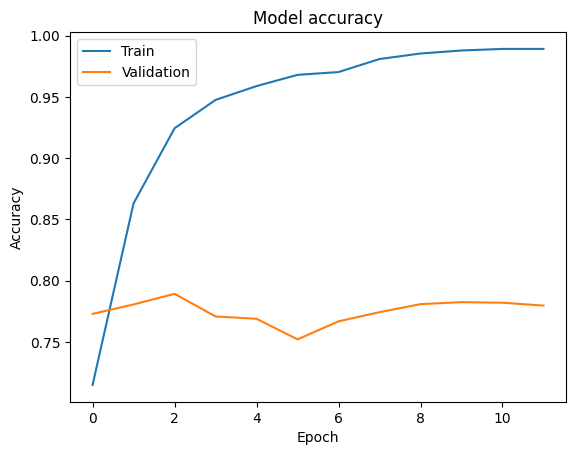

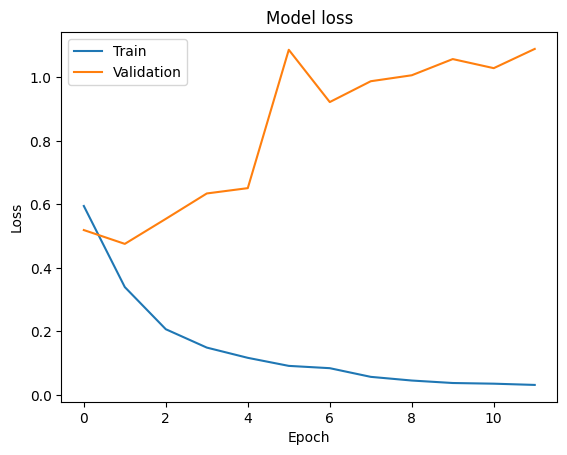

In [61]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

The graphs illustrate the training and validation performance of a model over several epochs.<br>

**Model Loss**
- Training Loss (Blue Line): Decreases steadily, indicating that the model is learning and fitting well to the training data.
- Validation Loss (Orange Line): Increases after a few epochs, suggesting the model is overfitting. It performs well on training data but poorly on unseen validation data.<br>

**Model Accuracy**
- Training Accuracy (Blue Line): Increases rapidly, approaching 100%, showing that the model is learning the training data effectively.
- Validation Accuracy (Orange Line): Remains relatively flat around 75-80%, indicating poor generalization to new data.<br>

**Interpretation**
- The model is likely overfitting. It memorizes the training data but does not generalize well to validation data.

In [62]:
_, train_acc = model.evaluate(x_train_token, y_train, verbose=2)
_, test_acc = model.evaluate(x_test_token, y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

668/668 - 5s - 7ms/step - acc: 0.9092 - loss: 0.2524
167/167 - 1s - 8ms/step - acc: 0.7808 - loss: 0.4879
Train: 0.909, Test: 0.7808


This summary indicates that the model achieved an accuracy of approximately 96.6% on the training data and approximately 79.03% on the test data.

These metrics suggest that while the model performs very well on the training data, its performance drops on unseen test data, which could indicate overfitting—where the model learns patterns specific to the training data but does not generalize well to new data.

In [63]:
y_pred = (model.predict(x_test_token) >= 0.5).astype("int32")
y_pred

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [1]], dtype=int32)

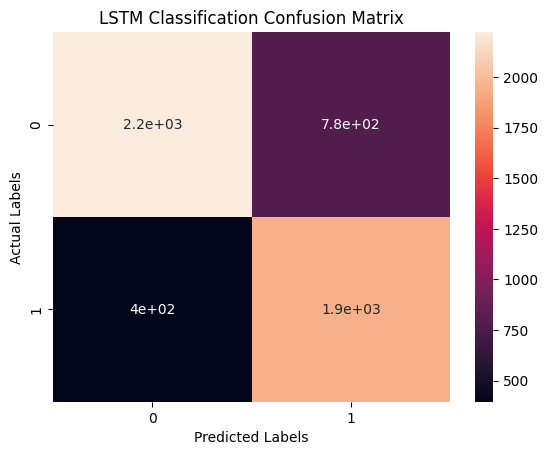

In [64]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

confusion_val = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_val, annot=True)
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.show()

The image is a confusion matrix for an LSTM (Long Short-Term Memory) classification model. A confusion matrix is a tool used to evaluate the performance of a classification algorithm by comparing predicted labels against actual labels.

Here’s a breakdown of the matrix:
- True Positives (TP): The bottom-right cell (1.9e+03) represents instances where the model correctly predicted the positive class.
- True Negatives (TN): The top-left cell (2.4e+03) shows instances where the model correctly predicted the negative class.
- False Positives (FP): The top-right cell (6.4e+02) indicates instances where the model incorrectly predicted the positive class.
- False Negatives (FN): The bottom-left cell (4.8e+02) represents instances where the model incorrectly predicted the negative class.

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79      2997
           1       0.72      0.83      0.77      2345

    accuracy                           0.78      5342
   macro avg       0.78      0.79      0.78      5342
weighted avg       0.79      0.78      0.78      5342



Overall, the accuracy of the model is reported as 0.78, indicating that approximately 78% of all predictions were correct.

### 5.2.3 LSTM Model #2

In [68]:
rnn_model = Sequential()
rnn_model.add(Input(shape=(max_length,)))
rnn_model.add(Embedding(len(encoder.get_vocabulary()),
                    64, mask_zero = True))
rnn_model.add(Bidirectional(LSTM(64, return_sequences = True, kernel_regularizer = l2(0.01))))
rnn_model.add(Dropout(0.3))
rnn_model.add(Bidirectional(LSTM(32)))
rnn_model.add(Dropout(0.3))
rnn_model.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.01)))
rnn_model.add(Dense(1))
rnn_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ (None, 30, 64)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 30, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
rnn_model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

history = rnn_model.fit(x_train_vectors_nn, y_train_vectors_nn,
                        epochs = 10,
                        batch_size = 32,
                        validation_split = 0.2)

Epoch 1/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.7150 - loss: 1.5465 - val_accuracy: 0.8285 - val_loss: 0.4541
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.8767 - loss: 0.3910 - val_accuracy: 0.8582 - val_loss: 0.5202
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9478 - loss: 0.2759 - val_accuracy: 0.8568 - val_loss: 0.7981
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step - accuracy: 0.9613 - loss: 0.2529 - val_accuracy: 0.8552 - val_loss: 0.9197
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9766 - loss: 0.1937 - val_accuracy: 0.7990 - val_loss: 1.3230
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - accuracy: 0.9560 - loss: 0.2388 - val_accuracy: 0.8051 - val_loss: 0.6573
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9706 - loss: 0.2164 - val_accuracy: 0.8402 - val_loss: 0.9725
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9834 - loss: 0.1675 - 

In [71]:
loss, accuracy = rnn_model.evaluate(x_test_vectors_nn, y_test_vectors_nn)
print(f"Accuracy: {accuracy:.2f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8370 - loss: 1.4136
Accuracy: 0.84


In [69]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape = (max_length,)))

    #embedding layer
    model.add(Embedding(len(encoder.get_vocabulary()),
                        hp.Int('embedding_dim', min_value = 32, max_value = 128, step = 32),
                        mask_zero = True))

    #LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences = True,
                                 kernel_regularizer = l2(hp.Choice('l2_reg_1', [0.01, 0.001, 0.0001])))))
    model.add(Dropout(hp.Choice('dropout_1', [0.2, 0.3, 0.5])))

    #LSTM layer
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(hp.Choice('dropout_2', [0.2, 0.3, 0.5])))

    #dense layer
    model.add(Dense(hp.Int('dense_units', min_value = 32, max_value = 128, step = 32),
                    activation = 'relu',
                    kernel_regularizer = l2(hp.Choice('l2_reg_2', [0.01, 0.001, 0.0001]))))
    model.add(Dropout(hp.Choice('dropout_3', [0.2, 0.3, 0.5])))

    #output layer
    model.add(Dense(1, activation = 'sigmoid'))

    #compile the model
    model.compile(
        optimizer= Adam(learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

In [81]:
# reloading output is because we ran it already and are just reloading the results of the cell
# only occurs if running the cell after you initially run the cell once

from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 2,
    directory = 'hyperparameter_tuning',
    project_name = 'lstm_tuning',
)


tuner.search(
    x_train_vectors_nn, y_train_vectors_nn,
    validation_split = 0.2,
    epochs = 20,
    batch_size = kt.HyperParameters().Choice('batch_size', [16, 32, 64]),
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)
    ]
)

Reloading Tuner from hyperparameter_tuning/lstm_tuning/tuner0.json


In [76]:
trials = tuner.oracle.trials
for trial_id, trial in trials.items():
    print(f"Trial ID: {trial_id}")
    print(f"  Hyperparameters: {trial.hyperparameters.values}")
    print(f"  Final Score: {trial.score}")
    print(f"  Status: {trial.status}")
    print("-" * 50)

Trial ID: 0
  Hyperparameters: {'embedding_dim': 64, 'l2_reg_1': 0.001, 'dropout_1': 0.3, 'dropout_2': 0.5, 'dense_units': 96, 'l2_reg_2': 0.0001, 'dropout_3': 0.2, 'learning_rate': 0.0005}
  Final Score: 0.8589143455028534
  Status: COMPLETED
--------------------------------------------------
Trial ID: 3
  Hyperparameters: {'embedding_dim': 64, 'l2_reg_1': 0.01, 'dropout_1': 0.5, 'dropout_2': 0.5, 'dense_units': 32, 'l2_reg_2': 0.0001, 'dropout_3': 0.5, 'learning_rate': 0.0005}
  Final Score: 0.8555217683315277
  Status: COMPLETED
--------------------------------------------------
Trial ID: 1
  Hyperparameters: {'embedding_dim': 128, 'l2_reg_1': 0.01, 'dropout_1': 0.3, 'dropout_2': 0.3, 'dense_units': 96, 'l2_reg_2': 0.01, 'dropout_3': 0.3, 'learning_rate': 0.0001}
  Final Score: 0.8611370921134949
  Status: COMPLETED
--------------------------------------------------
Trial ID: 4
  Hyperparameters: {'embedding_dim': 32, 'l2_reg_1': 0.01, 'dropout_1': 0.3, 'dropout_2': 0.3, 'dense_unit

In [77]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Dropout Rates:
    Dropout 1: {best_hps.get('dropout_1')}
    Dropout 2: {best_hps.get('dropout_2')}
    Dropout 3: {best_hps.get('dropout_3')}

Optimal L2 Regularization:
    L2 Reg 1: {best_hps.get('l2_reg_1')}
    L2 Reg 2: {best_hps.get('l2_reg_2')}

Optimal Dense Layer Units: {best_hps.get('dense_units')}
Optimal Learning Rate: {best_hps.get('learning_rate')}
Optimal Batch Size: {16}
""")


Optimal Dropout Rates:
    Dropout 1: 0.3
    Dropout 2: 0.3
    Dropout 3: 0.5

Optimal L2 Regularization:
    L2 Reg 1: 0.01
    L2 Reg 2: 0.0001

Optimal Dense Layer Units: 96
Optimal Learning Rate: 0.0005
Optimal Batch Size: 16



In [78]:
best_lstm_model = tuner.hypermodel.build(best_hps)

history = best_lstm_model.fit(
    x_train_vectors_nn, y_train_vectors_nn,
    validation_split = 0.2,
    epochs = 20,
    batch_size = 16,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)]
)

Epoch 1/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.7126 - loss: 0.8339 - val_accuracy: 0.8432 - val_loss: 0.3745
Epoch 2/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.9127 - loss: 0.2460 - val_accuracy: 0.8624 - val_loss: 0.3375
Epoch 3/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.9482 - loss: 0.1647 - val_accuracy: 0.8512 - val_loss: 0.4005
Epoch 4/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.9683 - loss: 0.1154 - val_accuracy: 0.8491 - val_loss: 0.4855
Epoch 5/20
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 38s 36ms/step - accuracy: 0.9780 - loss: 0.0822 - val_accuracy: 0.8432 - val_loss: 0.5883


In [80]:
loss, accuracy = best_lstm_model.evaluate(x_test_vectors_nn, y_test_vectors_nn)
print(f"Accuracy: {accuracy:.2f}")

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8587 - loss: 0.3419
Accuracy: 0.85


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


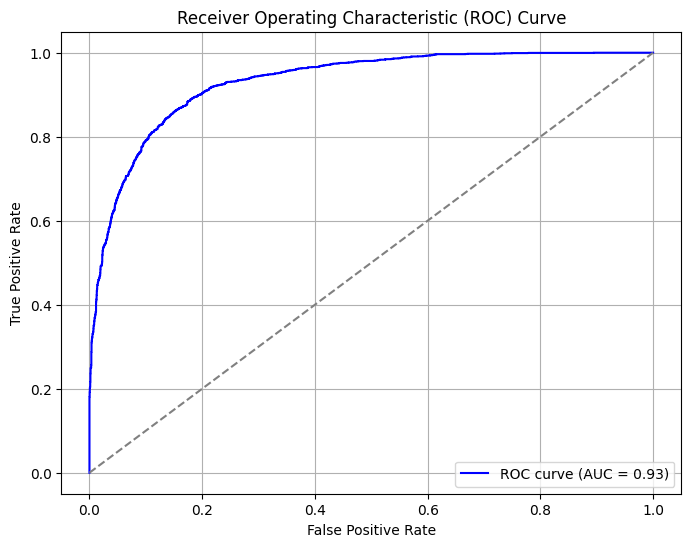

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_probs = best_lstm_model.predict(x_test_vectors_nn)

fpr, tpr, thresholds = roc_curve(y_test_vectors_nn, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

### 5.3 Pretrained-based methods

In this section, we will cover methods that will involve some sort of pretrained models. This includes:
- using a pretrained standard transformer-based model (such as the `BERT`-like `roBERTa`) and finetuning it for our actual objective. (We expect this to work well, since this approach is likely what would be used in practice as the constraints and problem objective closely align with with the general BERT-based approach.)
  - This approach is similiar to the LSTM approach we tried above; however, the main differences (and improvements) that will come from this method is the tried-and-true transformer architecture and the use of a pretrained foundation for the weights learned from a large corpus of data generally suited for these types of tasks.
- using a pretrained embedding model (like OpenAI's `text-embedding-3` large semantic embedding model) and using the returned vector as input to a linear classification model. (We do not expect this to work very well since semantic similarity will likely not translate well into sarcasm detection, but we thought it would be an interesting experiment.)

#### 5.3.1 Pretrained Semantic Embeddings

In [83]:
# setup openai
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

from openai import OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

In [84]:
# turn headlines into json format for sending to openai embedder
lines = []

for i, headline in enumerate(list(data_df.headline)):
  line = {"custom_id": f"request-{i+1}",
          "method": "POST",
          "url": "/v1/embeddings",
          "body": {"model": "text-embedding-3-small",
                   "input": headline,
                   "encoding_format": "float"}}

  lines.append(line)

In [85]:
# write headline in json format to jsonl file
with open('sarcasm.jsonl', 'w') as f:
    for line in lines:
      f.write(f'{json.dumps(line)}\n')

In [ ]:
# send combined jsonl file to openai
batch_input_file = client.files.create(
  file=open("sarcasm.jsonl", "rb"),
  purpose="batch"
)

In [ ]:
# queue and start openai embedding job using json file
batch_input_file_id = batch_input_file.id

batch_input_file_initial_response = client.batches.create(
    input_file_id=batch_input_file_id,
    endpoint="/v1/embeddings",
    completion_window="24h",
    metadata={
      "description": "initial sarcasm job"
    }
)

In [86]:
client.batches.retrieve('batch_67501c3df8988191a80a4e67735345a7')

Batch(id='batch_67501c3df8988191a80a4e67735345a7', completion_window='24h', created_at=1733303357, endpoint='/v1/embeddings', input_file_id='file-E7eFyQ36zmRUqYH69YWsPj', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1733309308, error_file_id=None, errors=None, expired_at=None, expires_at=1733389757, failed_at=None, finalizing_at=1733306366, in_progress_at=1733303362, metadata={'description': 'initial sarcasm job'}, output_file_id='file-CX15jA14Z5Jya3M5NpTN7U', request_counts=BatchRequestCounts(completed=26709, failed=0, total=26709))

In [87]:
file_response = client.files.content('file-CX15jA14Z5Jya3M5NpTN7U')

In [88]:
output_lines = file_response.text.splitlines()
display(output_lines[0])

'{"id": "batch_req_675027ff8c30819195b59f175a63e7ab", "custom_id": "request-1", "response": {"status_code": 200, "request_id": "4cd38b17f802187354eca0587c1bb631", "body": {"object": "list", "data": [{"object": "embedding", "index": 0, "embedding": [-0.015689993, -0.00051232247, -0.006784761, -0.014626011, 0.034197293, -0.020005865, -0.019061768, 0.019631224, -0.059942666, -0.056106336, 0.0129850805, -0.0064251046, -0.035126403, -0.007972375, -0.0069196317, 0.015450222, 0.051370867, -0.0180877, -0.034047436, 0.006012999, -0.0013131191, 0.098485805, 0.015899792, 0.019960908, -0.020140737, -0.006975828, -0.019766094, -0.04519677, 0.032518897, 0.01705369, 0.02649466, -0.026974201, 0.030271048, 0.0097931335, 0.0004343502, -0.0044919536, 0.030615717, -0.019930936, 0.07061246, -0.0043083793, -0.002491367, 0.005705793, 0.017443316, -0.028337896, 0.04402789, -0.01922661, 0.026404746, 0.014723418, 0.007346723, -0.0044994466, 0.010902072, -0.0005141957, -0.05182044, 0.05098124, -0.06629659, -0.01

In [89]:
# verify everything is good
# empty output if so

for i, output_line in enumerate(output_lines):
  output_json = json.loads(output_line)

  if output_json['response']['status_code'] != 200:
    print(i)
    print(output_json['response']['status_code'])
    print("")

In [90]:
openai_embeddings = []

for _, output_line in enumerate(output_lines):
  output_json = json.loads(output_line)

  embedding = output_json['response']['body']['data'][0]['embedding']

  openai_embeddings.append(embedding)

openai_np_embeddings = np.asarray(openai_embeddings)

In [326]:
X_temp_oai, X_test_oai, y_temp_oai, y_test_oai = train_test_split(openai_np_embeddings, y, stratify=y, test_size=0.2, random_state=42)
X_train_oai, X_val_oai, y_train_oai, y_val_oai = train_test_split(X_temp_oai, y_temp_oai, stratify=y_temp_oai, test_size=0.2, random_state=42)
print(f"Train: {X_train_oai.shape} {X_test_oai.shape} | Val: {X_val_oai.shape} {y_val_oai.shape} | Test: {X_test_oai.shape} {y_test_oai.shape}")

Train: (17093, 1536) (5342, 1536) | Val: (4274, 1536) (4274,) | Test: (5342, 1536) (5342,)


Accuracy: 0.8961063272182703

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      2997
           1       0.89      0.87      0.88      2345

    accuracy                           0.90      5342
   macro avg       0.90      0.89      0.89      5342
weighted avg       0.90      0.90      0.90      5342



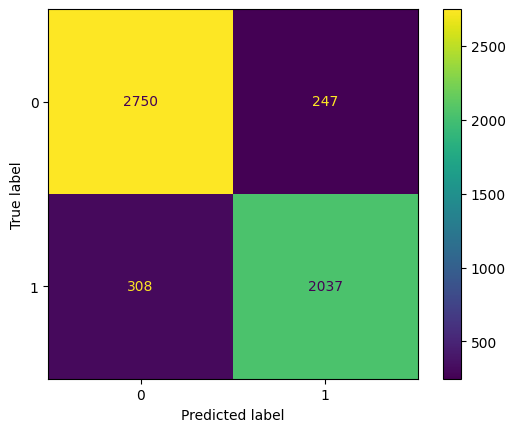

In [332]:
best_embedding_lr_model = LogisticRegression()
best_embedding_lr_model.fit(X_train_oai, y_train_oai)

y_pred_embedding_lr = best_embedding_lr_model.predict(X_test_oai)
y_pred_embedding_lr

accuracy_embedding_lr = accuracy_score(y_test_oai, y_pred_embedding_lr)
print(f"Accuracy: {accuracy_embedding_lr}")
print("\nClassification Report:\n", classification_report(y_test_oai, y_pred_embedding_lr))
disp = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test_oai, y_pred_embedding_lr))
disp.plot()

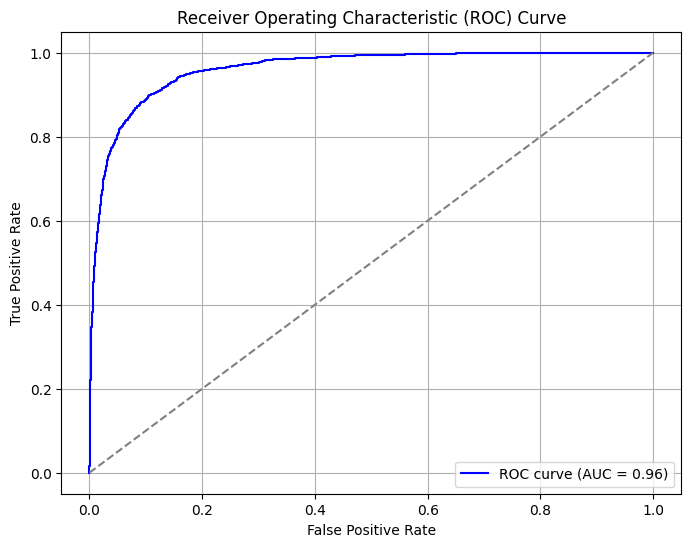

In [333]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_pred_probs = best_embedding_lr_model.predict_proba(X_test_oai)

fpr, tpr, thresholds = roc_curve(y_test_oai, y_pred_probs[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

#### 5.3.2 BERT-Based Approach

In [94]:
from datasets import Dataset

dataset = Dataset.from_dict({"text": list(data_df['headline']), "label": list(data_df['is_sarcastic'])})
dataset = dataset.train_test_split(test_size=0.2, shuffle=True)

In [95]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-cased")

def tokenize_function(examples):
  return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/21367 [00:00<?, ? examples/s]

Map:   0%|          | 0/5342 [00:00<?, ? examples/s]

In [96]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-cased", num_labels=2)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [100]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [101]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch")

In [102]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
)

In [103]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.326600,0.294946,0.904156
2,0.163400,0.380618,0.921191
3,0.051600,0.434590,0.920816


TrainOutput(global_step=8013, training_loss=0.20226806212524848, metrics={'train_runtime': 1407.6708, 'train_samples_per_second': 45.537, 'train_steps_per_second': 5.692, 'total_flos': 1.686568175963136e+16, 'train_loss': 0.20226806212524848, 'epoch': 3.0})

In [104]:
from evaluate import evaluator

In [105]:
task_evaluator = evaluator("text-classification")

data = dataset['test']

In [173]:
results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    data=data,
    metric="accuracy",
    label_mapping={"LABEL_0": 0.0, "LABEL_1": 1.0},
    strategy="simple"
)

display(results)

{'accuracy': 0.9208161737177087,
 'total_time_in_seconds': 23.681087762999596,
 'samples_per_second': 225.5808539482119,
 'latency_in_seconds': 0.004433000330026132}

In [174]:
results = task_evaluator.compute(
    model_or_pipeline=model,
    tokenizer=tokenizer,
    data=data,
    metric="f1",
    label_mapping={"LABEL_0": 0.0, "LABEL_1": 1.0},
    strategy="simple"
)

display(results)

{'f1': 0.9086590369250702,
 'total_time_in_seconds': 22.25146007299918,
 'samples_per_second': 240.07413367369085,
 'latency_in_seconds': 0.004165380021152972}

In [172]:
best_bert_model = model

In [178]:
from transformers import pipeline

classifier = pipeline("text-classification", model=best_bert_model, tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [336]:
bert_labels = []
bert_predict_probas = []

for text, label in list(zip(tokenized_datasets['test']['text'], tokenized_datasets['test']['label'])):
  classify = classifier(text)[0]

  if classify['label'] == 'LABEL_0':
    predict_proba = 1 - classify['score']
    label = 0
  else:
    predict_proba = classify['score']
    label = 1

  bert_labels.append(label)
  bert_predict_probas.append(predict_proba)

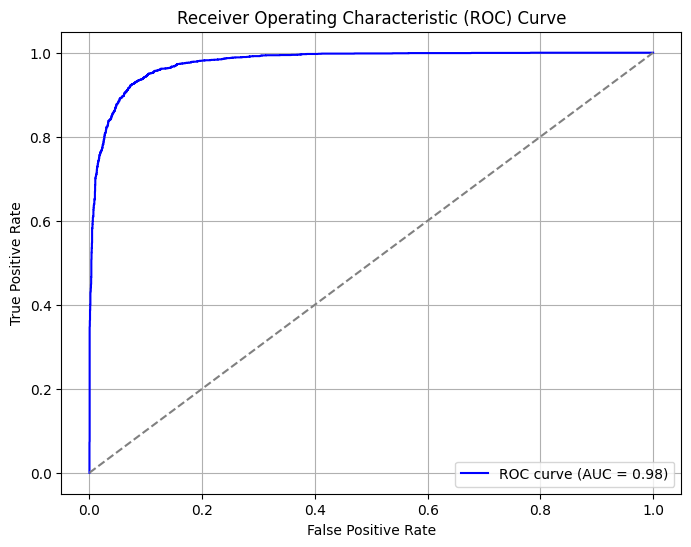

In [337]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(tokenized_datasets['test']['label'], bert_predict_probas)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 6. Final Comparison

## 6.1 Collating Final Models and Results

In [218]:
display(best_classic_model)

ExtraTreesClassifier(bootstrap=True, max_features='log2', min_samples_split=5)

In [221]:
display(best_simple_rnn_model)

<Sequential name=sequential_3, built=True>

In [222]:
display(best_lstm_model)

<Sequential name=sequential_1, built=True>

In [223]:
display(best_embedding_lr_model)

LogisticRegression()

In [224]:
display(best_bert_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [244]:
classic_y_test = y_test
classic_y_test_pred = best_classic_model.predict(x_test_vectors)
classic_y_test_pred_prob = best_classic_model.predict_proba(x_test_vectors)[:, 1]

In [344]:
simple_rnn_y_test = y_test
simple_rnn_y_test_pred_prob = best_simple_rnn_model.predict(x_test_token)
simple_rnn_y_test_pred = (simple_rnn_y_test_pred_prob >= 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [352]:
lstm_y_test = y_test_vectors_nn
lstm_y_test_pred_prob = best_lstm_model.predict(x_test_vectors_nn)
lstm_y_test_pred = (lstm_y_test_pred_prob >= 0.5).astype(int)

167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [334]:
embedding_lr_y_test = y_test_oai
embedding_lr_y_test_pred = best_embedding_lr_model.predict(X_test_oai)
embedding_lr_y_test_pred_prob = best_embedding_lr_model.predict_proba(X_test_oai)[:, 1]

In [340]:
bert_y_test = tokenized_datasets['test']['label']
bert_y_test_pred = np.asarray(bert_labels)
bert_y_test_pred_prob = np.asarray(bert_predict_probas)

In [358]:
final_results = {
    'best classic (extra trees)': (classic_y_test, classic_y_test_pred, classic_y_test_pred_prob),
    'simple rnn': (simple_rnn_y_test, simple_rnn_y_test_pred, simple_rnn_y_test_pred_prob),
    'lstm': (lstm_y_test, lstm_y_test_pred, lstm_y_test_pred_prob),
    'openai embedding -> logistic regression': (embedding_lr_y_test, embedding_lr_y_test_pred, embedding_lr_y_test_pred_prob),
    'bert finetuning': (bert_y_test, bert_y_test_pred, bert_y_test_pred_prob)
}

## 6.2 Accuracy Comparison

acc:
best classic (extra trees) -> 0.7933358292774242
simple rnn -> 0.760389367278173
lstm -> 0.8541744664919506
openai embedding -> logistic regression -> 0.8961063272182703
bert finetuning -> 0.9208161737177087


Text(0.5, 0, 'model name')

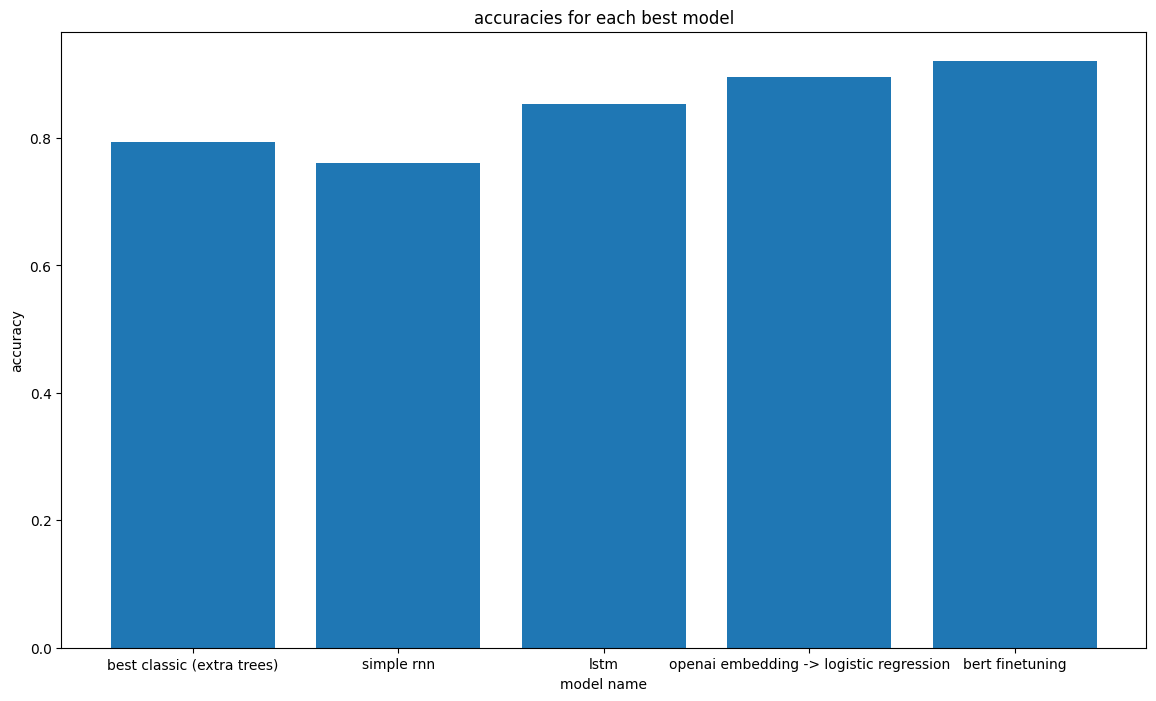

In [383]:
print("acc:")

accs = dict()
for model_name, (model_y_test, model_y_test_pred, model_y_test_pred_prob) in final_results.items():
  acc = accuracy_score(model_y_test, model_y_test_pred)
  accs[model_name] = acc
  print(model_name, '->', acc)

plt.figure(figsize=(14,8))
plt.bar(accs.keys(), accs.values())
plt.title('accuracies for each best model')
plt.ylabel('accuracy')
plt.xlabel('model name')

## 6.3 F1 Score Comparison

f1:
best classic (extra trees) -> 0.7494325919201089
simple rnn -> 0.7285835453774385
lstm -> 0.8320758784220738
openai embedding -> logistic regression -> 0.880103694102398
bert finetuning -> 0.9086590369250702


Text(0.5, 0, 'model name')

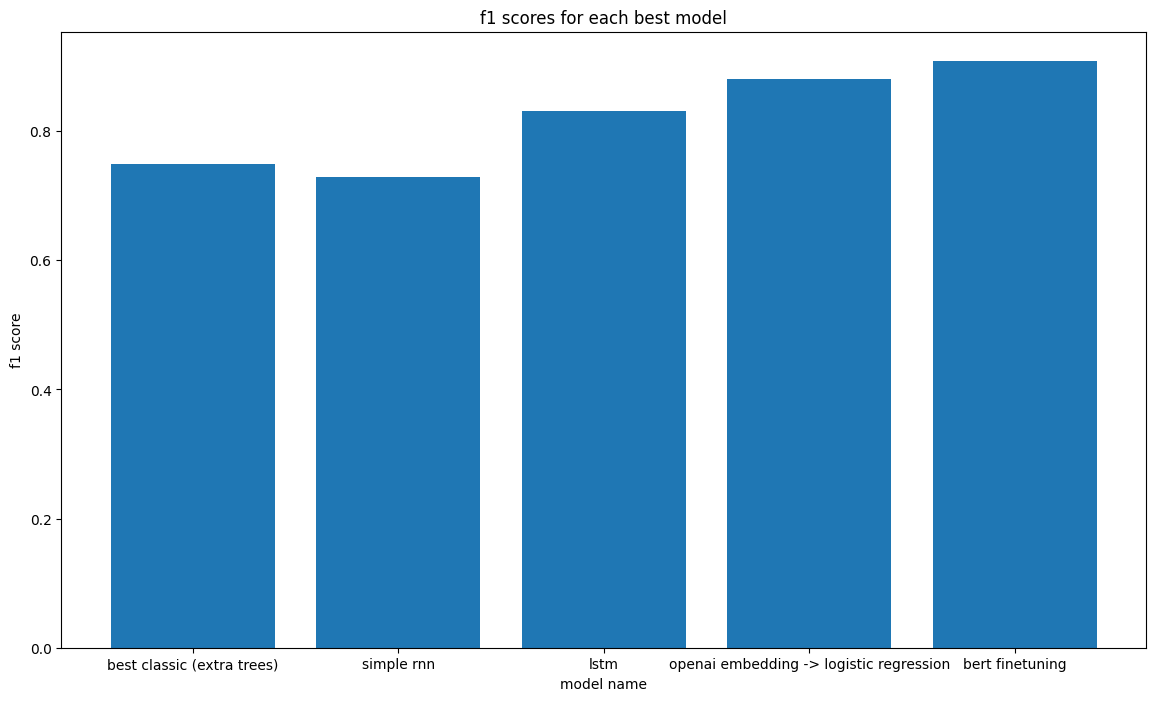

In [382]:
print("f1:")

f1s = dict()
for model_name, (model_y_test, model_y_test_pred, model_y_test_pred_prob) in final_results.items():
  f1 = f1_score(model_y_test, model_y_test_pred)
  f1s[model_name] = f1
  print(model_name, '->', f1)

plt.figure(figsize=(14,8))
plt.bar(f1s.keys(), f1s.values())
plt.title('f1 scores for each best model')
plt.ylabel('f1 score')
plt.xlabel('model name')

## 6.4 ROC Curve Comparison

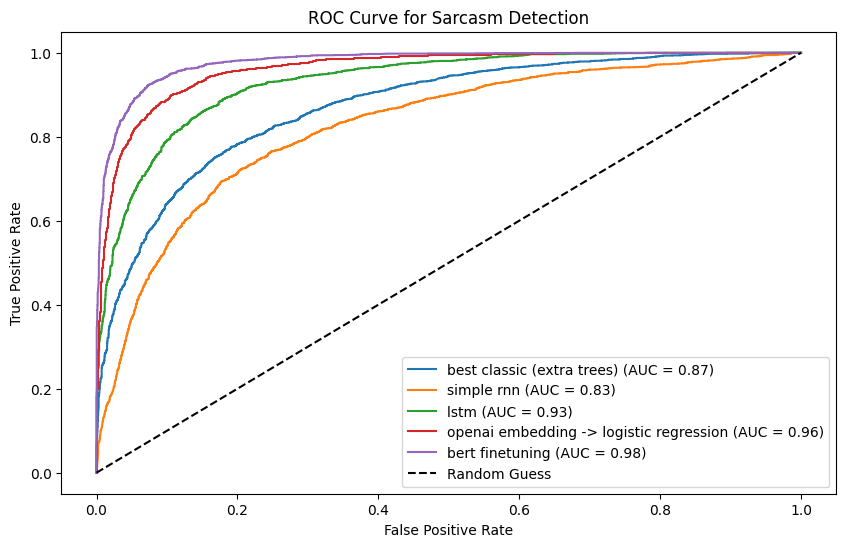

In [361]:
fig, ax = plt.subplots(figsize=(10, 6))

for model_name, (model_y_test, model_y_test_pred, model_y_test_pred_prob) in final_results.items():
    # ROC curve and AUC
    fpr, tpr, _ = roc_curve(model_y_test, model_y_test_pred_prob)
    auc_score = roc_auc_score(model_y_test, model_y_test_pred_prob)

    ax.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")

ax.plot([0, 1], [0, 1], "k--", label="Random Guess") # For reference
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curve for Sarcasm Detection")
ax.legend(loc="lower right")
plt.show()

## 6.5 Example Performance of Sarcasm Detection

In [408]:
# some example numbers
for i in [1, 2, 3, 5, 8, 13, 21, 34, 42]:
  print("HEADLINE:", tokenized_datasets['test']['text'][i])
  print(f"IS LABELED SARCASTIC?: {'YES' if tokenized_datasets['test']['label'][i] == 1 else 'NO'}")
  print(f"BERT MODEL PREDICTION: {'YES' if bert_y_test_pred[i] == 1 else 'NO'}")
  print("")

HEADLINE: women in business q&a: laura tenison, founder and managing director, jojo maman bébé
IS LABELED SARCASTIC?: NO
BERT MODEL PREDICTION: NO

HEADLINE: native american activists create spoof website to call for redskins name change
IS LABELED SARCASTIC?: NO
BERT MODEL PREDICTION: NO

HEADLINE: sixth-grader's family tree fails to hold up to scrutiny
IS LABELED SARCASTIC?: YES
BERT MODEL PREDICTION: YES

HEADLINE: harry reid: republicans are 'acting as puppets for the nra'
IS LABELED SARCASTIC?: NO
BERT MODEL PREDICTION: NO

HEADLINE: alderman has that zoning dream again
IS LABELED SARCASTIC?: YES
BERT MODEL PREDICTION: YES

HEADLINE: older cousin thinks it about time to have uninformed sex talk with area 8-year-old
IS LABELED SARCASTIC?: YES
BERT MODEL PREDICTION: YES

HEADLINE: kitchen staff warned not to make fun of regional manager
IS LABELED SARCASTIC?: YES
BERT MODEL PREDICTION: YES

HEADLINE: negligent oaf sloppily packs away board game without so much as a thought to future

In [ ]:
E